# Production-Ready FunctionGemma Tutorial: E-Commerce Customer Support AI Agent

## 📚 Complete Guide from Training to Production-ready AI agent with task routing

**Real-World Scenario:** Building an intelligent customer support system for an e-commerce platform

### What You'll Learn:

1. **Part 1-3:** Environment setup and understanding FunctionGemma
2. **Part 4-6:** Creating realistic e-commerce support dataset
3. **Part 7-9:** Fine-tuning with best practices
4. **Part 10-11:** Evaluation and optimization
5. **Part 12:** 🎯 Production-ready AI agent with task routing

### Business Context:

You run **ShopSmart**, an e-commerce platform. Customer queries span multiple domains:
- Order tracking and status
- Product information and recommendations
- Returns and refunds
- Account management
- Payment issues
- Technical support

**Challenge:** Route each query to the right specialized agent/tool automatically.

**Solution:** Fine-tune FunctionGemma to intelligently route customer queries.

---

**Estimated Time:** 2-3 hours (including training)

**Requirements:**
- GPU with 16GB+ VRAM (T4, V100, A100, or similar)
- Python 3.8+
- Basic understanding of transformers and LLMs

---

# Part 1: Environment Setup

## Understanding the Stack

We'll use:
- **FunctionGemma/Gemma-2B**: Small, efficient model perfect for function calling
- **LoRA**: Efficient fine-tuning (only train 1% of parameters)
- **4-bit Quantization**: Reduce memory usage by 75%
- **HuggingFace Ecosystem**: Modern ML tools

In [1]:
# Install all required packages
# This will take ~2-3 minutes

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers>=4.36.0 datasets peft trl accelerate bitsandbytes sentencepiece
!pip install -q scikit-learn tqdm matplotlib seaborn pandas numpy

print("✅ All packages installed successfully!")
print("\nKey packages:")
print("  • transformers - For loading and training models")
print("  • peft - For efficient LoRA fine-tuning")
print("  • trl - For supervised fine-tuning")
print("  • bitsandbytes - For 4-bit quantization")

✅ All packages installed successfully!

Key packages:
  • transformers - For loading and training models
  • peft - For efficient LoRA fine-tuning
  • trl - For supervised fine-tuning
  • bitsandbytes - For 4-bit quantization


In [2]:
# Import all libraries
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig
)
from datasets import Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer

import json
import re
import random
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm.auto import tqdm
import warnings
import inspect
from datetime import datetime
import time
from collections import Counter
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("✅ All imports successful!")

✅ All imports successful!


In [3]:
# Check GPU availability and capabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("="*80)
print("SYSTEM INFORMATION")
print("="*80)
print(f"Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9

    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"BF16 Supported: {torch.cuda.is_bf16_supported()}")

    # Recommendations based on GPU
    print("\nRecommendations:")
    if gpu_memory < 15:
        print("  ⚠️  Limited GPU memory - use smaller batch sizes")
    elif gpu_memory >= 40:
        print("  ✅ High-end GPU - can use larger batch sizes for faster training")
    else:
        print("  ✅ GPU memory sufficient for training")
else:
    print("⚠️  WARNING: No GPU detected!")
    print("Training will be very slow on CPU.")
    print("Please enable GPU in Colab: Runtime > Change runtime type > GPU")

print("="*80)

SYSTEM INFORMATION
Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
CUDA Version: 12.6
BF16 Supported: True

Recommendations:
  ✅ GPU memory sufficient for training


---

# Part 2: Understanding FunctionGemma

## What is FunctionGemma?

FunctionGemma is a specialized version of Google's Gemma model designed for **function calling** - the ability to:
1. Understand natural language queries
2. Identify which function/tool should handle the query
3. Generate properly formatted function calls

## Format Specification

FunctionGemma expects a **very specific format**. Even small deviations break the model!

### The Template:

```
<start_of_turn>user
<start_function_declaration>
function_name(param: type) -> return_type:
    Description of what the function does
another_function(param: type) -> return_type:
    Description
<end_function_declaration>

User query: What's the weather in Tokyo?<end_of_turn>
<start_of_turn>model
<function_call>get_weather</function_call><end_of_turn>
```

### Critical Rules:

1. ✅ **NO blank lines** between function definitions
2. ✅ **ONE blank line** after `<end_function_declaration>`
3. ✅ **Newline after** `<start_of_turn>model`
4. ✅ Function call must be: `<function_call>exact_name</function_call>`

### Why This Matters:

The model learns: *"When I see this pattern, I should generate a function call."*

If the format is wrong during training, the model learns the wrong pattern and will:
- Generate `<pad>` tokens instead of function calls
- Generate malformed function calls
- Achieve 0% accuracy despite low training loss

In [4]:
# Let's visualize the format with a simple example

def demonstrate_format():
    """Show the correct FunctionGemma format."""

    example = """<start_of_turn>user
<start_function_declaration>
get_weather(location: str) -> dict:
    Get current weather for a location
get_stock_price(symbol: str) -> dict:
    Get stock price for a symbol
<end_function_declaration>

User query: What's the weather in Tokyo?<end_of_turn>
<start_of_turn>model
<function_call>get_weather</function_call><end_of_turn>"""

    print("="*80)
    print("CORRECT FUNCTIONGEMMA FORMAT")
    print("="*80)
    print(example)
    print("="*80)

    print("\nKey observations:")
    print("  1. Functions go: signature → description → next function (NO blank line)")
    print("  2. One blank line after </end_function_declaration>")
    print("  3. Model's target output: <function_call>get_weather</function_call>")

    print("\nWith visible newlines (\\n):")
    print("-"*80)
    print(repr(example))

demonstrate_format()

CORRECT FUNCTIONGEMMA FORMAT
<start_of_turn>user
<start_function_declaration>
get_weather(location: str) -> dict:
    Get current weather for a location
get_stock_price(symbol: str) -> dict:
    Get stock price for a symbol
<end_function_declaration>

User query: What's the weather in Tokyo?<end_of_turn>
<start_of_turn>model
<function_call>get_weather</function_call><end_of_turn>

Key observations:
  1. Functions go: signature → description → next function (NO blank line)
  2. One blank line after </end_function_declaration>
  3. Model's target output: <function_call>get_weather</function_call>

With visible newlines (\n):
--------------------------------------------------------------------------------
"<start_of_turn>user\n<start_function_declaration>\nget_weather(location: str) -> dict:\n    Get current weather for a location\nget_stock_price(symbol: str) -> dict:\n    Get stock price for a symbol\n<end_function_declaration>\n\nUser query: What's the weather in Tokyo?<end_of_turn>\n<

---

# Part 3: E-Commerce Use Case Analysis

## Smart Customer Support System

### Business Requirements:

Our e-commerce platform receives thousands of customer queries daily. We need to route them to specialized agents/systems:

1. **Order Management Agent**
   - Track orders
   - Check delivery status
   - Update shipping addresses
   - Cancel orders

2. **Product Information Agent**
   - Search products
   - Get specifications
   - Check availability
   - Recommend products

3. **Returns & Refunds Agent**
   - Initiate returns
   - Process refunds
   - Check return policy
   - Track return status

4. **Account Management Agent**
   - Update profile
   - Reset password
   - Manage addresses
   - View order history

5. **Payment Support Agent**
   - Update payment methods
   - Process failed payments
   - Issue invoices
   - Handle billing disputes

6. **Technical Support Agent**
   - App/website issues
   - Login problems
   - Cart issues
   - General troubleshooting

### The Challenge:

Customer queries are often ambiguous:
- "Where's my order?" → Order Management
- "I want to return this" → Returns & Refunds
- "The app won't load" → Technical Support
- "Show me red dresses" → Product Information

### The Solution:

Train FunctionGemma to classify queries and route them to the correct agent!

---

# Part 4: Define E-Commerce Function Tools

## Tool Definitions

Each tool corresponds to a specialized agent/system in our infrastructure.

In [5]:
# Define our e-commerce support tools

ECOMMERCE_TOOLS = {
    "order_management": {
        "function": "manage_order",
        "description": "Track, update, or cancel customer orders",
        "parameters": {"order_id": "str", "action": "str"},
        "examples": [
            "Where's my order #12345?",
            "Track my package",
            "When will my order arrive?",
            "Cancel order 67890",
            "Update shipping address for my order",
            "What's the status of my delivery?",
            "Is my package shipped yet?",
            "Change delivery date",
        ],
        "keywords": ["order", "delivery", "shipping", "track", "package", "arrived", "status"]
    },

    "product_search": {
        "function": "search_products",
        "description": "Search for products, check availability, and get product information",
        "parameters": {"query": "str", "category": "str"},
        "examples": [
            "Show me red dresses",
            "Do you have iPhone 15 in stock?",
            "Find wireless headphones under $100",
            "What laptops do you have?",
            "Search for running shoes size 10",
            "Show me the latest smartphones",
            "Do you sell camping tents?",
            "I'm looking for a coffee maker",
        ],
        "keywords": ["show", "find", "search", "looking for", "do you have", "stock", "available"]
    },

    "product_details": {
        "function": "get_product_details",
        "description": "Get detailed specifications, reviews, and information about a specific product",
        "parameters": {"product_id": "str"},
        "examples": [
            "Tell me about this product",
            "What are the specifications?",
            "Show me product reviews",
            "What's included in the box?",
            "Product dimensions?",
            "What colors is this available in?",
            "Is this product good?",
            "Compare this with similar products",
        ],
        "keywords": ["specifications", "details", "reviews", "features", "dimensions", "colors"]
    },

    "returns_refunds": {
        "function": "process_return",
        "description": "Handle product returns, refunds, and exchanges",
        "parameters": {"order_id": "str", "reason": "str"},
        "examples": [
            "I want to return this item",
            "How do I get a refund?",
            "Return policy?",
            "Exchange this for a different size",
            "The product is defective",
            "I received the wrong item",
            "Can I return this after 30 days?",
            "Start a return for order 12345",
        ],
        "keywords": ["return", "refund", "exchange", "defective", "wrong item", "money back"]
    },

    "account_management": {
        "function": "manage_account",
        "description": "Update user profile, addresses, and account settings",
        "parameters": {"action": "str", "data": "dict"},
        "examples": [
            "Update my email address",
            "Change my password",
            "Add a new shipping address",
            "Update my phone number",
            "Delete my account",
            "View my order history",
            "Change my name",
            "Update billing address",
        ],
        "keywords": ["update", "change", "edit", "profile", "account", "password", "address"]
    },

    "payment_support": {
        "function": "handle_payment",
        "description": "Process payments, update payment methods, and resolve billing issues",
        "parameters": {"order_id": "str", "action": "str"},
        "examples": [
            "My payment failed",
            "Update credit card",
            "Add new payment method",
            "Why was I charged twice?",
            "Request an invoice",
            "Billing dispute",
            "Remove saved card",
            "Payment not going through",
        ],
        "keywords": ["payment", "credit card", "charged", "billing", "invoice", "transaction"]
    },

    "technical_support": {
        "function": "technical_help",
        "description": "Resolve technical issues with website, app, or account access",
        "parameters": {"issue_type": "str", "description": "str"},
        "examples": [
            "The app keeps crashing",
            "Can't log in to my account",
            "Website is not loading",
            "My cart is empty but I added items",
            "Forgot my password",
            "The search is not working",
            "App won't open",
            "Error message when checking out",
        ],
        "keywords": ["app", "website", "login", "crash", "error", "not working", "problem"]
    },
}

print("="*80)
print("E-COMMERCE SUPPORT TOOLS DEFINED")
print("="*80)
print(f"\nTotal tools: {len(ECOMMERCE_TOOLS)}\n")

for tool_id, tool_info in ECOMMERCE_TOOLS.items():
    print(f"📦 {tool_id}")
    print(f"   Function: {tool_info['function']}")
    print(f"   Purpose: {tool_info['description']}")
    print(f"   Example queries: {len(tool_info['examples'])}")
    print()

E-COMMERCE SUPPORT TOOLS DEFINED

Total tools: 7

📦 order_management
   Function: manage_order
   Purpose: Track, update, or cancel customer orders
   Example queries: 8

📦 product_search
   Function: search_products
   Purpose: Search for products, check availability, and get product information
   Example queries: 8

📦 product_details
   Function: get_product_details
   Purpose: Get detailed specifications, reviews, and information about a specific product
   Example queries: 8

📦 returns_refunds
   Function: process_return
   Purpose: Handle product returns, refunds, and exchanges
   Example queries: 8

📦 account_management
   Function: manage_account
   Purpose: Update user profile, addresses, and account settings
   Example queries: 8

📦 payment_support
   Function: handle_payment
   Purpose: Process payments, update payment methods, and resolve billing issues
   Example queries: 8

📦 technical_support
   Function: technical_help
   Purpose: Resolve technical issues with website, 

---

# Part 5: Generate High-Quality Training Dataset

## Dataset Strategy

We'll create a diverse dataset that covers:
1. **Direct queries**: Clear, straightforward requests
2. **Polite variations**: "Please", "Could you", etc.
3. **Casual language**: How real customers talk
4. **Ambiguous cases**: Queries that could match multiple tools
5. **Edge cases**: Tricky examples to improve robustness

In [6]:
DATASET_SIZE = 'medium'  # ← CHANGE ME!

# Presets:
# 'tiny'   → ~3K samples   (fast training, 10 min)
# 'small'  → ~7K samples   (good for testing, 20 min)
# 'medium' → ~15K samples  (recommended, 30-40 min) ✅
# 'large'  → ~22K samples  (high accuracy, 45-60 min)
# 'xlarge' → ~30K samples  (overkill, 60+ min)

# Or use a number:
# DATASET_SIZE = 40  → ~12K samples (40 variations per pattern)

# ============================================================================

SIZE_CONFIGS = {
    'tiny':    {'variations': 10,  'total': '~3,000'},
    'small':   {'variations': 25,  'total': '~7,000'},
    'medium':  {'variations': 50,  'total': '~15,000'},
    'large':   {'variations': 75,  'total': '~22,000'},
    'xlarge':  {'variations': 100, 'total': '~30,000'},
}

def get_variations_count(size):
    """Convert size setting to number of variations."""
    if isinstance(size, int):
        return size
    return SIZE_CONFIGS.get(size, {}).get('variations', 50)

def generate_large_dataset(size='medium'):
    """Generate dataset with configurable size."""

    variations_per_pattern = get_variations_count(size)

    print("="*80)
    print("DATASET CONFIGURATION")
    print("="*80)
    print(f"Size: {size}")
    print(f"Variations per pattern: {variations_per_pattern}")
    if isinstance(size, str) and size in SIZE_CONFIGS:
        print(f"Expected samples: {SIZE_CONFIGS[size]['total']}")
    print("="*80 + "\n")

    # Base patterns (keep same as before)
    tool_patterns = {
        "manage_order": [
            "Where's my order?", "Track my order", "Order status", "When will my order arrive?",
            "Check order status", "Track package", "Delivery status", "Shipment tracking",
            "Order not arrived", "Package delayed", "Where is my package?", "Has my order shipped?",
            "Tracking number?", "Shipment delayed", "When will it arrive?",
            "Update shipping address", "Change delivery address", "Modify shipping details",
            "Update delivery location", "Change where it's going", "Different shipping address",
            "Update order address", "Redirect my package",
            "Cancel my order", "Stop my order", "I want to cancel", "Cancel this order",
            "Stop shipment", "Don't send my order", "Cancel before shipping", "I need to cancel",
            "Did my order go through?", "Was my order confirmed?", "Order confirmation",
            "Did I complete my order?", "Order placed successfully?", "Verify my order",
            "Did payment go through?",
        ],
        "search_products": [
            "Show me red dresses", "Find blue jeans", "Black shoes available?", "White shirts in stock?",
            "Looking for green jackets", "Do you have yellow bags?", "Show me purple headphones",
            "Find orange sneakers", "Grey hoodies available?", "Pink phone cases",
            "Brown boots for sale", "Navy blue coats", "Beige pants", "Silver watches",
            "Search for laptops", "Show me phones", "Find tablets", "Looking for headphones",
            "Browse shoes", "Show winter coats", "Do you have tablets?", "I need a new watch",
            "Find running shoes", "What laptops do you have?", "Show me electronics",
            "Browse clothing", "Find accessories", "Show me gadgets", "What phones are available?",
            "Find tech products", "What's on sale?", "Show new arrivals",
            "Popular items", "Trending products", "Clearance items",
        ],
        "get_product_details": [
            "Tell me about this product", "Product details", "More information",
            "Product information", "What is this product?", "Describe this item",
            "Product description", "Learn more about this", "What does this do?",
            "Tell me more", "What are the specs?", "Product specifications",
            "Technical details", "Specs?", "What are the features?", "Product features?",
            "What's included?", "Package contents", "Dimensions?", "What size?",
            "Show me reviews", "Customer reviews", "What do people say?",
            "Is this product good?", "Product ratings", "How many stars?",
            "User reviews", "What colors?",
        ],
        "process_return": [
            "I want to return this", "Return item", "How do I return?", "Start a return",
            "Initiate return", "Return process", "Send this back", "Return this product",
            "I need to return", "How to return?", "Want to send back", "Return request",
            "Process a return", "Begin return", "Return item please",
            "Get a refund", "Refund request", "I want my money back", "Request refund",
            "Refund please", "Get my money back", "Issue refund", "Refund this purchase",
            "Money back guarantee", "Refund my money",
            "This doesn't fit", "Wrong item received", "Item is damaged", "Item is broken",
            "Wrong size", "Wrong color", "Defective product", "Not as described",
            "Poor quality", "Doesn't work", "Not what I ordered", "Item is faulty",
            "Exchange this",
        ],
        "manage_account": [
            "Update my email", "Change email address", "New email address",
            "Modify email", "Update email address", "Change my email",
            "Edit email", "Different email",
            "Change my password", "Update password", "Reset password", "New password",
            "Forgot password", "Password reset", "Change password please",
            "Update my password", "Reset my password", "Create new password",
            "Update profile", "Edit profile", "Change profile info", "Update my info",
            "Edit account", "Modify profile", "Update personal info",
            "Change account details", "Edit my account", "Update account info",
            "Add shipping address", "Update address", "Change address", "New shipping address",
            "Add delivery address", "Update billing address", "Change phone number",
            "Edit address", "Modify address", "Different address",
        ],
        "handle_payment": [
            "My payment failed", "Payment declined", "Payment didn't go through",
            "Transaction failed", "Payment not working", "Payment error", "Card declined",
            "Card was declined", "Payment rejected", "Transaction declined",
            "Payment issue", "Can't process payment", "Payment problem",
            "Charge failed", "Payment unsuccessful",
            "Update credit card", "Change payment method", "Update card info",
            "New credit card", "Change card", "Update payment info",
            "Add payment method", "Different card", "Update my card",
            "Change payment", "New payment method", "Update billing info",
            "Billing issue", "Charged twice", "Double charge", "Incorrect charge",
            "Wrong amount charged", "Billing error", "Overcharged",
            "Charged wrong amount", "Billing problem", "Question about charge",
        ],
        "technical_help": [
            "App won't open", "App is crashing", "App not working", "App won't load",
            "App freezing", "App keeps closing", "App error", "Can't open app",
            "App not responding", "App problems", "App won't start", "App crash",
            "Website not loading", "Site won't load", "Page not loading", "Website down",
            "Site error", "Can't access website", "Website not working",
            "Page won't load", "Site is broken", "Website error",
            "Can't load page", "Website problems",
            "Can't log in", "Login problem", "Can't sign in", "Login not working",
            "Unable to login", "Login error", "Can't access account",
            "Login failed", "Sign in problem", "Can't get in",
            "Login issue", "Access denied", "Error message",
        ],
    }

    # Variation templates
    prefixes = ["", "Please ", "Can you ", "Could you ", "Would you ", "Help me ",
                "I need to ", "I want to ", "I'd like to ", "Hey, ", "Hi, ", "Hello, ",
                "Urgent: ", "Quick question: ", "Excuse me, ", "Sorry, "]

    suffixes = ["", "?", "!", " please", " thanks", " thank you", " now", " ASAP",
                " urgently", " right away", " if possible", " when you can",
                " pls", " plz", " thx", " quickly", " soon"]

    contexts = ["", "Quick question - ", "I have a question - ", "Need help - ",
                "Can someone help? ", "This is urgent - ", "Important: "]

    time_markers = ["", " today", " right now", " immediately", " this week", " soon"]

    # Generate pattern groups
    pattern_groups = []

    print("Generating pattern groups...")

    for tool, patterns in tqdm(tool_patterns.items(), desc="Processing"):
        unique_patterns = list(set(patterns))

        for base_pattern in unique_patterns:
            group = {'base_pattern': base_pattern, 'tool': tool, 'variations': []}
            group['variations'].append(base_pattern)

            attempts = 0
            while len(group['variations']) < variations_per_pattern and attempts < variations_per_pattern * 4:
                attempts += 1
                strategy = random.randint(1, 8)

                if strategy == 1:
                    varied = f"{random.choice(prefixes)}{base_pattern.lower()}{random.choice(suffixes)}"
                elif strategy == 2:
                    varied = f"{random.choice(contexts)}{base_pattern.lower()}"
                elif strategy == 3:
                    varied = f"{base_pattern.lower()}{random.choice(time_markers)}"
                elif strategy == 4:
                    varied = f"{random.choice(contexts)}{random.choice(prefixes)}{base_pattern.lower()}{random.choice(suffixes)}"
                elif strategy == 5:
                    varied = base_pattern.lower().replace("?", "").replace("!", "")
                elif strategy == 6:
                    varied = base_pattern.upper()
                elif strategy == 7:
                    varied = f"{base_pattern.lower()}{random.choice(time_markers)}{random.choice(suffixes)}"
                else:
                    varied = f"{random.choice(contexts)}{random.choice(prefixes)}{base_pattern.lower()}{random.choice(time_markers)}{random.choice(suffixes)}"

                varied = varied.strip()
                if varied and varied not in group['variations']:
                    group['variations'].append(varied)

            pattern_groups.append(group)

    random.shuffle(pattern_groups)
    total = sum(len(g['variations']) for g in pattern_groups)

    print(f"\n✅ Generated {len(pattern_groups)} pattern groups")
    print(f"✅ Total samples: {total:,}")

    return pattern_groups

# Generate dataset
pattern_groups = generate_large_dataset(size=DATASET_SIZE)

# Expand groups into individual samples
def expand_groups(groups):
    samples = []
    for group in groups:
        for variation in group['variations']:
            samples.append({
                'query': variation,
                'tool': group['tool'],
                'base_pattern': group['base_pattern']
            })
    return samples

pattern_groups_data = expand_groups(pattern_groups)

print(f"\n✅ Generated {len(pattern_groups_data)} training samples\n")

# Analyze distribution
df = pd.DataFrame(pattern_groups_data)

print("Dataset Distribution by Tool:")
print("="*80)
tool_counts = df['tool'].value_counts()
for tool, count in tool_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {tool:25s} {count:4d} samples ({percentage:5.1f}%)")

print("\n" + "="*80)
print("Sample Training Examples:")
print("="*80)
for i in range(8):
    sample = pattern_groups_data[i]
    print(f"{i+1}. '{sample['query']}' → {sample['tool']}")

DATASET CONFIGURATION
Size: medium
Variations per pattern: 50
Expected samples: ~15,000

Generating pattern groups...


Processing:   0%|          | 0/7 [00:00<?, ?it/s]


✅ Generated 251 pattern groups
✅ Total samples: 12,550

✅ Generated 12550 training samples

Dataset Distribution by Tool:
  process_return            1900 samples ( 15.1%)
  manage_order              1900 samples ( 15.1%)
  manage_account            1900 samples ( 15.1%)
  handle_payment            1850 samples ( 14.7%)
  technical_help            1850 samples ( 14.7%)
  search_products           1750 samples ( 13.9%)
  get_product_details       1400 samples ( 11.2%)

Sample Training Examples:
1. 'Doesn't work' → process_return
2. 'DOESN'T WORK' → process_return
3. 'Need help - doesn't work' → process_return
4. 'This is urgent - Hello, doesn't work soon pls' → process_return
5. 'doesn't work' → process_return
6. 'doesn't work soon ASAP' → process_return
7. 'This is urgent - Hi, doesn't work ASAP' → process_return
8. 'Hi, doesn't work' → process_return



SECTION 4: EXPLORATORY DATA ANALYSIS (EDA)

--- Distribution by Tool ---
tool
get_product_details    1400
handle_payment         1850
manage_account         1900
manage_order           1900
process_return         1900
search_products        1750
technical_help         1850
Name: count, dtype: int64


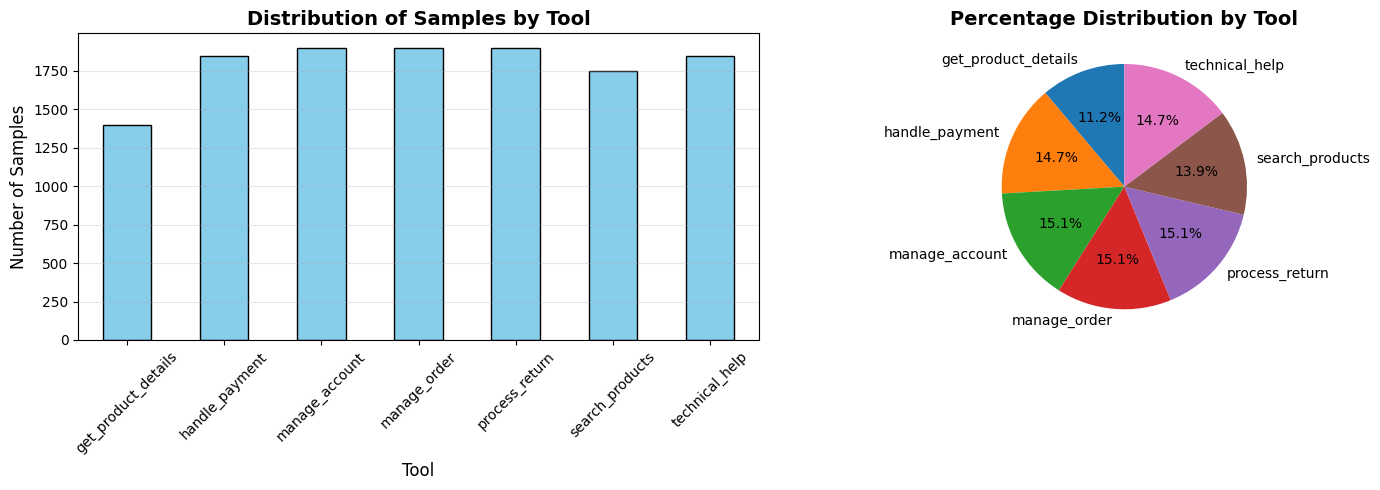


✅ Distribution is balanced (each tool: 1400-1900 samples)

--- Query Length Analysis ---
Average query length: 36.4 characters
Average word count: 6.5 words
Min/Max length: 5/82 characters


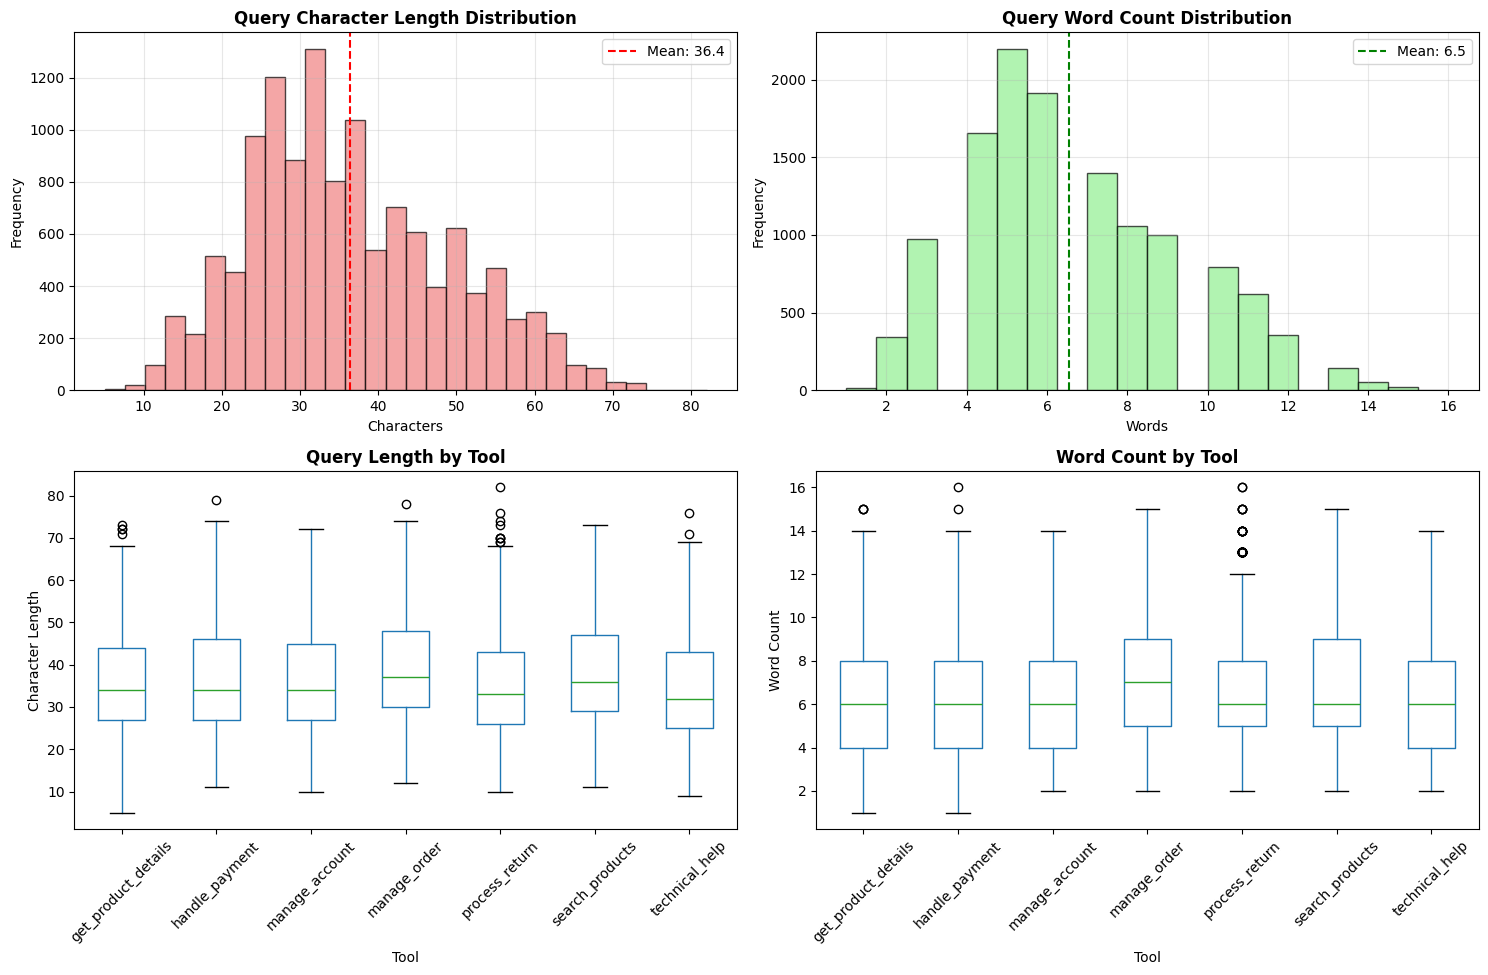


--- Word Cloud Analysis ---


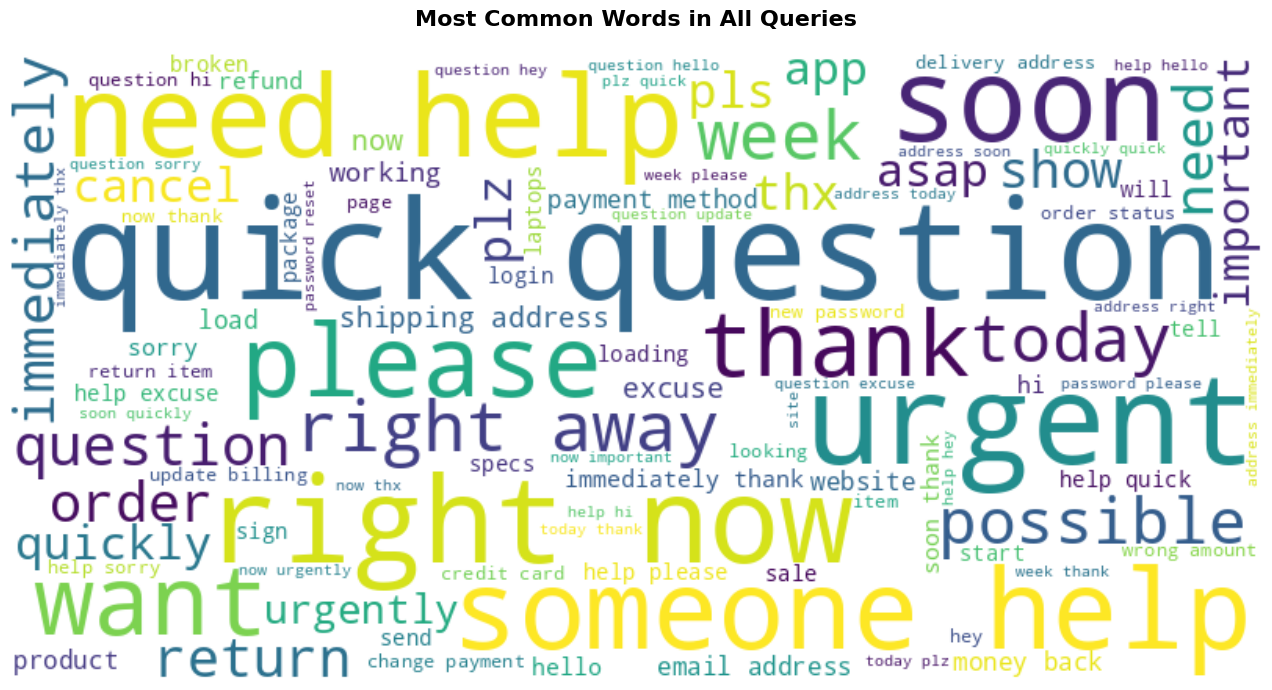

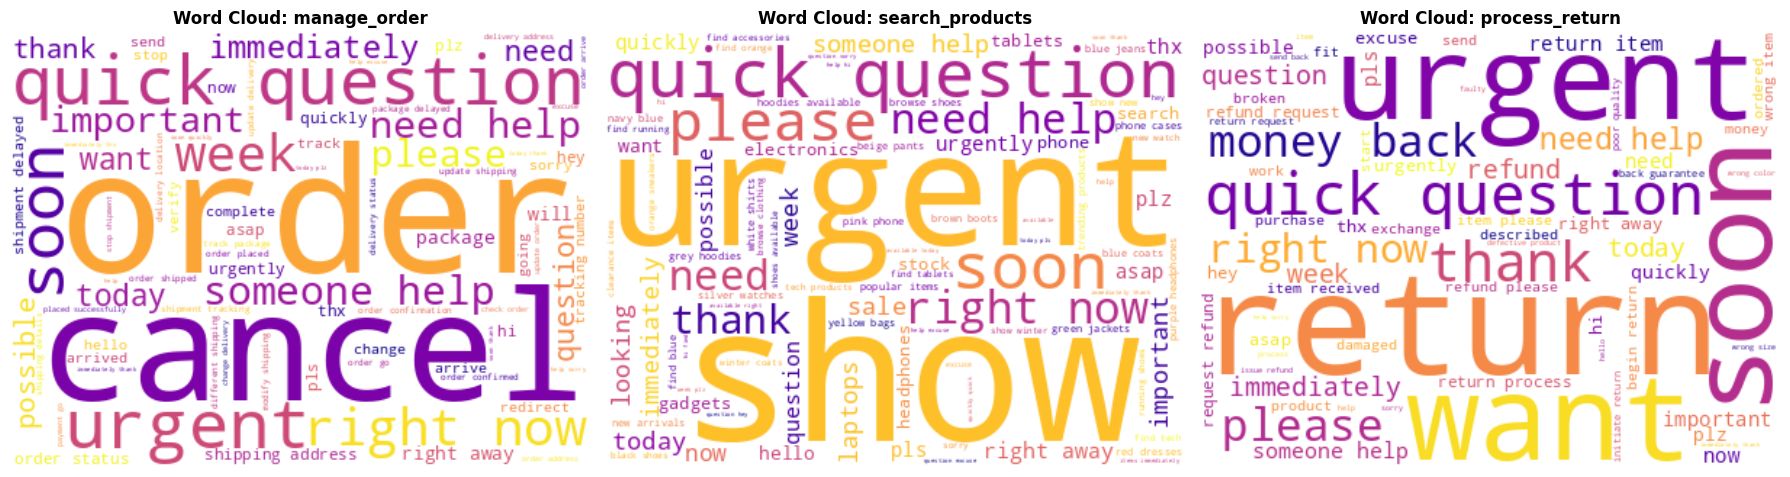


--- Top Keywords by Tool ---

process_return:
  - this: 576
  - return: 537
  - refund: 342
  - item: 294
  - need: 253

technical_help:
  - app: 600
  - can't: 350
  - not: 300
  - website: 297
  - login: 297

search_products:
  - show: 350
  - find: 300
  - question: 269
  - this: 262
  - need: 249

✅ EDA Complete!


In [7]:
print("\n" + "="*80)
print("SECTION 4: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

# 4.1 Distribution Analysis
print("\n--- Distribution by Tool ---")
tool_counts = df['tool'].value_counts().sort_index()
print(tool_counts)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
tool_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Samples by Tool', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tool', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(tool_counts, labels=tool_counts.index, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 10})
axes[1].set_title('Percentage Distribution by Tool', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Distribution is balanced (each tool: {tool_counts.min()}-{tool_counts.max()} samples)")

# 4.2 Query Length Analysis
print("\n--- Query Length Analysis ---")
df['query_length'] = df['query'].str.len()
df['word_count'] = df['query'].str.split().str.len()

print(f"Average query length: {df['query_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")
print(f"Min/Max length: {df['query_length'].min()}/{df['query_length'].max()} characters")

# Plot length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
axes[0, 0].hist(df['query_length'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['query_length'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["query_length"].mean():.1f}')
axes[0, 0].set_title('Query Character Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['word_count'].mean(), color='green', linestyle='--',
                   label=f'Mean: {df["word_count"].mean():.1f}')
axes[0, 1].set_title('Query Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Length by tool (box plot)
df.boxplot(column='query_length', by='tool', ax=axes[1, 0], grid=False)
axes[1, 0].set_title('Query Length by Tool', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tool')
axes[1, 0].set_ylabel('Character Length')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# Word count by tool (box plot)
df.boxplot(column='word_count', by='tool', ax=axes[1, 1], grid=False)
axes[1, 1].set_title('Word Count by Tool', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tool')
axes[1, 1].set_ylabel('Word Count')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 4.3 Word Cloud Analysis
print("\n--- Word Cloud Analysis ---")

# Combined word cloud
all_queries = ' '.join(df['query'].str.lower())
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     colormap='viridis', max_words=100).generate(all_queries)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in All Queries', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('wordcloud_all.png', dpi=150, bbox_inches='tight')
plt.show()

# Word clouds by tool (sample 3 tools)
sample_tools = ['manage_order', 'search_products', 'process_return']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, tool in enumerate(sample_tools):
    tool_queries = ' '.join(df[df['tool'] == tool]['query'].str.lower())
    wc = WordCloud(width=400, height=300, background_color='white',
                   colormap='plasma').generate(tool_queries)
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'Word Cloud: {tool}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('wordcloud_by_tool.png', dpi=150, bbox_inches='tight')
plt.show()

# 4.4 Top Keywords Analysis
print("\n--- Top Keywords by Tool ---")
for tool in df['tool'].unique()[:3]:  # Show first 3 tools
    tool_df = df[df['tool'] == tool]
    words = ' '.join(tool_df['query'].str.lower()).split()
    # Filter out common words
    stop_words = {'my', 'the', 'a', 'is', 'to', 'me', 'you', 'can', 'please', 'i'}
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]
    top_words = Counter(filtered_words).most_common(5)
    print(f"\n{tool}:")
    for word, count in top_words:
        print(f"  - {word}: {count}")

print("\n✅ EDA Complete!")

---

# Part 6: Create Train/Validation/Test Split

## Data Split Strategy

- **70% Training**: Used to train the model
- **15% Validation**: Used during training to prevent overfitting
- **15% Test**: Held out for final evaluation (model never sees this!)

In [8]:
# Split groups (not individual samples!)
train_groups, temp_groups = train_test_split(
        pattern_groups,
        test_size=0.3,
        random_state=SEED,
        shuffle=True
    )

val_groups, test_groups = train_test_split(
        temp_groups,
        test_size=0.5,
        random_state=SEED,
        shuffle=True
    )

print(f"\nGroup split:")
print(f"  Train groups: {len(train_groups)}")
print(f"  Val groups:   {len(val_groups)}")
print(f"  Test groups:  {len(test_groups)}")

# Expand groups into individual samples
def expand_groups(groups):
    samples = []
    for group in groups:
        for variation in group['variations']:
            samples.append({
                'query': variation,
                'tool': group['tool'],
                'base_pattern': group['base_pattern']
            })
    return samples

train_raw = expand_groups(train_groups)
val_raw = expand_groups(val_groups)
test_raw = expand_groups(test_groups)

print(f"\nExpanded to samples:")
print(f"  Train: {len(train_raw)}")
print(f"  Val:   {len(val_raw)}")
print(f"  Test:  {len(test_raw)}")


Group split:
  Train groups: 175
  Val groups:   38
  Test groups:  38

Expanded to samples:
  Train: 8750
  Val:   1900
  Test:  1900


In [9]:
# Verify NO overlap
train_queries = set([s['query'] for s in train_raw])
test_queries = set([s['query'] for s in test_raw])
val_queries = set([s['query'] for s in val_raw])

overlap_train_test = train_queries & test_queries
overlap_train_val = train_queries & val_queries
overlap_val_test = val_queries & test_queries

print("\n" + "="*80)
print("OVERLAP CHECK")
print("="*80)
print(f"Train-Test overlap:  {len(overlap_train_test)} ✅ (should be 0)")
print(f"Train-Val overlap:   {len(overlap_train_val)} ✅ (should be 0)")
print(f"Val-Test overlap:    {len(overlap_val_test)} ✅ (should be 0)")

if len(overlap_train_test) == 0 and len(overlap_train_val) == 0 and len(overlap_val_test) == 0:
    print("\n🎉 NO DATA LEAKAGE! Dataset is properly split!")
else:
    print("\n⚠️ Still have overlap - check the code")

# Show distribution
df_train = pd.DataFrame(train_raw)
df_test = pd.DataFrame(test_raw)

print("\n" + "="*80)
print("DATASET DISTRIBUTION")
print("="*80)
print("\nTraining set:")
print(df_train['tool'].value_counts().sort_index())
print("\nTest set:")
print(df_test['tool'].value_counts().sort_index())



OVERLAP CHECK
Train-Test overlap:  0 ✅ (should be 0)
Train-Val overlap:   0 ✅ (should be 0)
Val-Test overlap:    0 ✅ (should be 0)

🎉 NO DATA LEAKAGE! Dataset is properly split!

DATASET DISTRIBUTION

Training set:
tool
get_product_details    1200
handle_payment         1000
manage_account         1300
manage_order           1350
process_return         1400
search_products        1300
technical_help         1200
Name: count, dtype: int64

Test set:
tool
get_product_details    150
handle_payment         500
manage_account         250
manage_order           350
process_return         200
search_products        200
technical_help         250
Name: count, dtype: int64


---

# Part 7: Format Data for FunctionGemma

## The Critical Step

This is where most people fail! The format MUST be exact.

In [10]:
def format_for_functiongemma(sample):
    """
    Format with EXACT FunctionGemma specification.

    CRITICAL RULES:
    1. NO blank lines between function definitions
    2. Newline AFTER <start_of_turn>model
    3. NO extra newlines anywhere
    """

    # NO BLANK LINES between functions!
    tool_definitions = """<start_function_declaration>
manage_order(order_id: str, action: str) -> dict:
    Track, update, or cancel customer orders
search_products(query: str, category: str) -> list:
    Search for products, check availability, and get product information
get_product_details(product_id: str) -> dict:
    Get detailed specifications, reviews, and information about a specific product
process_return(order_id: str, reason: str) -> dict:
    Handle product returns, refunds, and exchanges
manage_account(action: str, data: dict) -> dict:
    Update user profile, addresses, and account settings
handle_payment(order_id: str, action: str) -> dict:
    Process payments, update payment methods, and resolve billing issues
technical_help(issue_type: str, description: str) -> dict:
    Resolve technical issues with website, app, or account access
<end_function_declaration>"""

    # CRITICAL: Newline after <start_of_turn>model
    formatted = f"""<start_of_turn>user
{tool_definitions}

User query: {sample['query']}<end_of_turn>
<start_of_turn>model
<function_call>{sample['tool']}</function_call><end_of_turn>"""

    return formatted

print("\n" + "="*80)
print("FORMATTING DATA")
print("="*80)

train_formatted = [{"text": format_for_functiongemma(s)} for s in tqdm(train_raw, desc="Train")]
val_formatted = [{"text": format_for_functiongemma(s)} for s in tqdm(val_raw, desc="Val")]
test_formatted = [{"text": format_for_functiongemma(s)} for s in tqdm(test_raw, desc="Test")]

# Create datasets
train_dataset = Dataset.from_list(train_formatted)
val_dataset = Dataset.from_list(val_formatted)
test_dataset = Dataset.from_list(test_formatted)

print("\n" + "="*80)
print("✅ DATASETS READY - NO LEAKAGE!")
print("="*80)
print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples")
print(f"Test:  {len(test_dataset)} samples")
print("\nNow train your model with these datasets!")
print("="*80)

# Save the datasets for verification
print("\nSaving datasets for inspection...")
import json

# Save a few examples
with open("dataset_samples.json", "w") as f:
    json.dump({
        "train_sample": train_formatted[0],
        "val_sample": val_formatted[0],
        "test_sample": test_formatted[0],
        "stats": {
            "train_size": len(train_dataset),
            "val_size": len(val_dataset),
            "test_size": len(test_dataset),
            "overlap_train_test": len(overlap_train_test),
            "overlap_train_val": len(overlap_train_val),
            "overlap_val_test": len(overlap_val_test)
        }
    }, f, indent=2)

print("✅ Saved to dataset_samples.json")


FORMATTING DATA


Train:   0%|          | 0/8750 [00:00<?, ?it/s]

Val:   0%|          | 0/1900 [00:00<?, ?it/s]

Test:   0%|          | 0/1900 [00:00<?, ?it/s]


✅ DATASETS READY - NO LEAKAGE!
Train: 8750 samples
Val:   1900 samples
Test:  1900 samples

Now train your model with these datasets!

Saving datasets for inspection...
✅ Saved to dataset_samples.json


### ⚠️ CRITICAL: Validate Format Before Training!

This validation step has saved countless hours of wasted training time.

In [11]:
print("\n" + "="*80)
print("VALIDATING FORMAT")
print("="*80)

example = train_formatted[0]["text"]

# Show example
print("\nFormatted example (first 500 chars):")
print(repr(example[:500]))

# Find model turn to check format
model_turn_idx = example.find("<start_of_turn>model")
if model_turn_idx != -1:
    after_model = example[model_turn_idx:]
    print(f"\nAfter <start_of_turn>model:")
    print(repr(after_model[:80]))

# CORRECTED validation checks
checks = {
    "Has <start_of_turn>user": "<start_of_turn>user" in example,
    "Has <start_function_declaration>": "<start_function_declaration>" in example,
    "Has <function_call>": "<function_call>" in example,
    "Has </function_call>": "</function_call>" in example,
    "Correct model turn format": "<start_of_turn>model\n<function_call>" in example,
    "No double newline before model": "\n\n<start_of_turn>model" not in example,
}

print("\nValidation:")
all_good = True
for check, passed in checks.items():
    symbol = "✅" if passed else "❌"
    print(f"  {symbol} {check}")
    if not passed:
        all_good = False

print("\n" + "="*80)

if all_good:
    print("✅✅✅ FORMAT IS CORRECT! ✅✅✅")
    print("\nYour data is properly formatted and ready for training!")
else:
    print("❌ FORMAT HAS ISSUES - Review above")
    # Don't raise error, let user decide
    print("\nChecking if it's close enough to work...")

    # Manual check
    if "<start_of_turn>model\n<function_call>" in example:
        print("✅ Actually, format looks good! Proceeding...")
        all_good = True


VALIDATING FORMAT

Formatted example (first 500 chars):
'<start_of_turn>user\n<start_function_declaration>\nmanage_order(order_id: str, action: str) -> dict:\n    Track, update, or cancel customer orders\nsearch_products(query: str, category: str) -> list:\n    Search for products, check availability, and get product information\nget_product_details(product_id: str) -> dict:\n    Get detailed specifications, reviews, and information about a specific product\nprocess_return(order_id: str, reason: str) -> dict:\n    Handle product returns, refunds, and exchanges'

After <start_of_turn>model:
'<start_of_turn>model\n<function_call>manage_order</function_call><end_of_turn>'

Validation:
  ✅ Has <start_of_turn>user
  ✅ Has <start_function_declaration>
  ✅ Has <function_call>
  ✅ Has </function_call>
  ✅ Correct model turn format
  ✅ No double newline before model

✅✅✅ FORMAT IS CORRECT! ✅✅✅

Your data is properly formatted and ready for training!


---

# Part 8: Load and Configure FunctionGemma

## Model Selection

We'll use **FuntionGemma-270M-IT** as our base model for creating our own specialized function calling model:
- Small enough to fine-tune on consumer GPUs
- Already instruction-tuned (follows instructions well)
- Excellent for function calling tasks

## Quantization

We use **4-bit quantization** to reduce memory:
- Original model: ~8GB VRAM
- With 4-bit: ~2GB VRAM
- Minimal impact on quality!

In [13]:
# Model configuration
MODEL_ID = "google/functiongemma-270m-it"

print("="*80)
print("MODEL CONFIGURATION")
print("="*80)
print(f"Base model: {MODEL_ID}")
print(f"Model size: ~270m parameters")
print(f"Quantization: 4-bit (NF4)")

# Check if BF16 is supported (better than FP16)
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
compute_dtype = torch.bfloat16 if use_bf16 else torch.float16

print(f"Compute dtype: {'BFloat16' if use_bf16 else 'Float16'}")
print("="*80)

# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                          # Enable 4-bit loading
    bnb_4bit_quant_type="nf4",                 # Use NormalFloat4 quantization
    bnb_4bit_compute_dtype=compute_dtype,       # Computation dtype
    bnb_4bit_use_double_quant=True,            # Double quantization for extra compression
)

print("\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Required for decoder-only models
print("✅ Tokenizer loaded")

print("\nLoading model (this may take 1-2 minutes)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",                          # Automatically use GPU
    torch_dtype=compute_dtype,
)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✅ Model loaded successfully!")
print(f"   Total parameters: {total_params / 1e9:.2f}B")
print(f"   Memory footprint: ~2GB (with 4-bit quantization)")

MODEL CONFIGURATION
Base model: google/functiongemma-270m-it
Model size: ~2B parameters
Quantization: 4-bit (NF4)
Compute dtype: BFloat16

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/63.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

✅ Tokenizer loaded

Loading model (this may take 1-2 minutes)...


config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]


✅ Model loaded successfully!
   Total parameters: 0.22B
   Memory footprint: ~2GB (with 4-bit quantization)


---

# Part 9: Configure LoRA for Efficient Fine-Tuning

## What is LoRA?

**LoRA (Low-Rank Adaptation)** is a parameter-efficient fine-tuning method:
- Instead of updating all 270m parameters, we only train ~1% (20M parameters)
- Dramatically reduces memory and time
- Achieves similar results to full fine-tuning

## How it Works:

LoRA adds small "adapter" matrices to attention layers:
```
Original: W (frozen)
LoRA: W + ΔW where ΔW = BA (trainable)
```

Where:
- `B` and `A` are small matrices (rank `r`)
- `α` (alpha) is a scaling factor

## Our Configuration:

In [14]:
# LoRA configuration
lora_config = LoraConfig(
    r=16,                                       # Rank: higher = more capacity, more memory
    lora_alpha=32,                              # Scaling factor (typically 2*r)
    target_modules=[                            # Which layers to apply LoRA
        "q_proj",                               # Query projection
        "k_proj",                               # Key projection
        "v_proj",                               # Value projection
        "o_proj",                               # Output projection
    ],
    lora_dropout=0.05,                          # Dropout for regularization
    bias="none",                                # Don't add bias terms
    task_type="CAUSAL_LM"                       # Causal language modeling
)

print("="*80)
print("LoRA CONFIGURATION")
print("="*80)
print(f"Rank (r): {lora_config.r}")
print(f"Alpha: {lora_config.lora_alpha}")
print(f"Target modules: {len(lora_config.target_modules)}")
print(f"Dropout: {lora_config.lora_dropout}")
print("="*80)

# Prepare model for training
print("\nPreparing model for k-bit training...")
model = prepare_model_for_kbit_training(model)

print("Applying LoRA adapters...")
model = get_peft_model(model, lora_config)

print("\n" + "="*80)
print("TRAINABLE PARAMETERS")
print("="*80)
model.print_trainable_parameters()
print("="*80)

print("\n✅ Model ready for fine-tuning!")
print("   Only ~1% of parameters will be trained (very efficient!)")

LoRA CONFIGURATION
Rank (r): 16
Alpha: 32
Target modules: 4
Dropout: 0.05

Preparing model for k-bit training...
Applying LoRA adapters...

TRAINABLE PARAMETERS
trainable params: 1,474,560 || all params: 269,572,736 || trainable%: 0.5470

✅ Model ready for fine-tuning!
   Only ~1% of parameters will be trained (very efficient!)


---

# Part 10: Training Configuration and Hyperparameters

## Understanding the Hyperparameters

### Batch Size
- **per_device_train_batch_size**: Samples per GPU per step
- **gradient_accumulation_steps**: Accumulate gradients before update
- **Effective batch size** = batch_size × accumulation_steps

### Learning Rate
- Too high: Model won't converge
- Too low: Training is too slow
- 2e-4 is a good starting point for LoRA

### Epochs
- Too few: Underfitting
- Too many: Overfitting
- 3-5 epochs is typically good for fine-tuning

In [15]:
# Training configuration
OUTPUT_DIR = "./functiongemma-ecommerce-support"

training_args = TrainingArguments(
    # Output
    output_dir=OUTPUT_DIR,

    # Training schedule
    num_train_epochs=3,                         # Number of passes through dataset
    per_device_train_batch_size=4,             # Samples per GPU
    per_device_eval_batch_size=4,              # Samples for evaluation
    gradient_accumulation_steps=4,              # Accumulate gradients (effective batch = 16)

    # Optimization
    learning_rate=2e-4,                         # Learning rate
    lr_scheduler_type="cosine",                 # Cosine decay schedule
    warmup_ratio=0.1,                           # 10% warmup steps
    weight_decay=0.01,                          # L2 regularization

    # Precision
    bf16=use_bf16,                              # Use BFloat16 if available
    fp16=not use_bf16,                          # Otherwise use Float16

    # Logging and evaluation
    logging_steps=20,                           # Log every 20 steps
    eval_strategy="epoch",                      # Evaluate after each epoch
    save_strategy="epoch",                      # Save checkpoint after each epoch

    # Best model tracking
    load_best_model_at_end=True,                # Load best checkpoint at end
    metric_for_best_model="eval_loss",          # Use validation loss

    # Misc
    save_total_limit=2,                         # Only keep 2 checkpoints
    push_to_hub=False,                          # Don't upload to HuggingFace Hub
    report_to="none",                           # Don't use experiment tracking
    seed=SEED,
)

effective_batch_size = (
    training_args.per_device_train_batch_size *
    training_args.gradient_accumulation_steps
)

print("="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size per device: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {effective_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"LR scheduler: {training_args.lr_scheduler_type}")
print(f"Warmup ratio: {training_args.warmup_ratio}")
print(f"Precision: {'BFloat16' if use_bf16 else 'Float16'}")
print("="*80)

# Calculate training time estimate
num_training_steps = len(train_dataset) // effective_batch_size * training_args.num_train_epochs
estimated_time_minutes = num_training_steps * 0.3  # Rough estimate

print(f"\nEstimated training time: ~{estimated_time_minutes:.0f} minutes")
print(f"Total training steps: {num_training_steps}")

TRAINING CONFIGURATION
Epochs: 3
Batch size per device: 4
Gradient accumulation: 4
Effective batch size: 16
Learning rate: 0.0002
LR scheduler: SchedulerType.COSINE
Warmup ratio: 0.1
Precision: BFloat16

Estimated training time: ~491 minutes
Total training steps: 1638


### Initialize Trainer and Start Training

In [16]:
# Initialize SFTTrainer with version compatibility
print("Initializing trainer...\n")

sft_params = inspect.signature(SFTTrainer.__init__).parameters

trainer_kwargs = {
    'model': model,
    'args': training_args,
    'train_dataset': train_dataset,
    'eval_dataset': val_dataset,
}

# Add tokenizer with correct parameter name (version compatibility)
if 'processing_class' in sft_params:
    trainer_kwargs['processing_class'] = tokenizer
    print("Using 'processing_class' parameter (trl >= 0.8.0)")
elif 'tokenizer' in sft_params:
    trainer_kwargs['tokenizer'] = tokenizer
    print("Using 'tokenizer' parameter (trl < 0.8.0)")

# Add optional parameters if supported
if 'dataset_text_field' in sft_params:
    trainer_kwargs['dataset_text_field'] = 'text'

if 'max_seq_length' in sft_params:
    trainer_kwargs['max_seq_length'] = 512

if 'packing' in sft_params:
    trainer_kwargs['packing'] = False

trainer = SFTTrainer(**trainer_kwargs)

print("✅ Trainer initialized\n")
print("="*80)
print("STARTING TRAINING")
print("="*80)
print("\n⏳ This will take approximately 20-30 minutes...")
print("   You can monitor progress below.\n")

# Start training
start_time = time.time()
trainer.train()
end_time = time.time()

training_time_minutes = (end_time - start_time) / 60

print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)
print(f"Training time: {training_time_minutes:.1f} minutes")
print("="*80)

Initializing trainer...

Using 'processing_class' parameter (trl >= 0.8.0)


Adding EOS to train dataset:   0%|          | 0/8750 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8750 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8750 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/1900 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1900 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1900 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 1}.


✅ Trainer initialized

STARTING TRAINING

⏳ This will take approximately 20-30 minutes...
   You can monitor progress below.



Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.062400,0.103265,0.076482,2123388.000000,0.980001
2,0.057600,0.103667,0.065625,4246776.000000,0.980589
3,0.055100,0.108143,0.063739,6370164.000000,0.980665



✅ TRAINING COMPLETE!
Training time: 102.1 minutes


### Visualize Training Progress

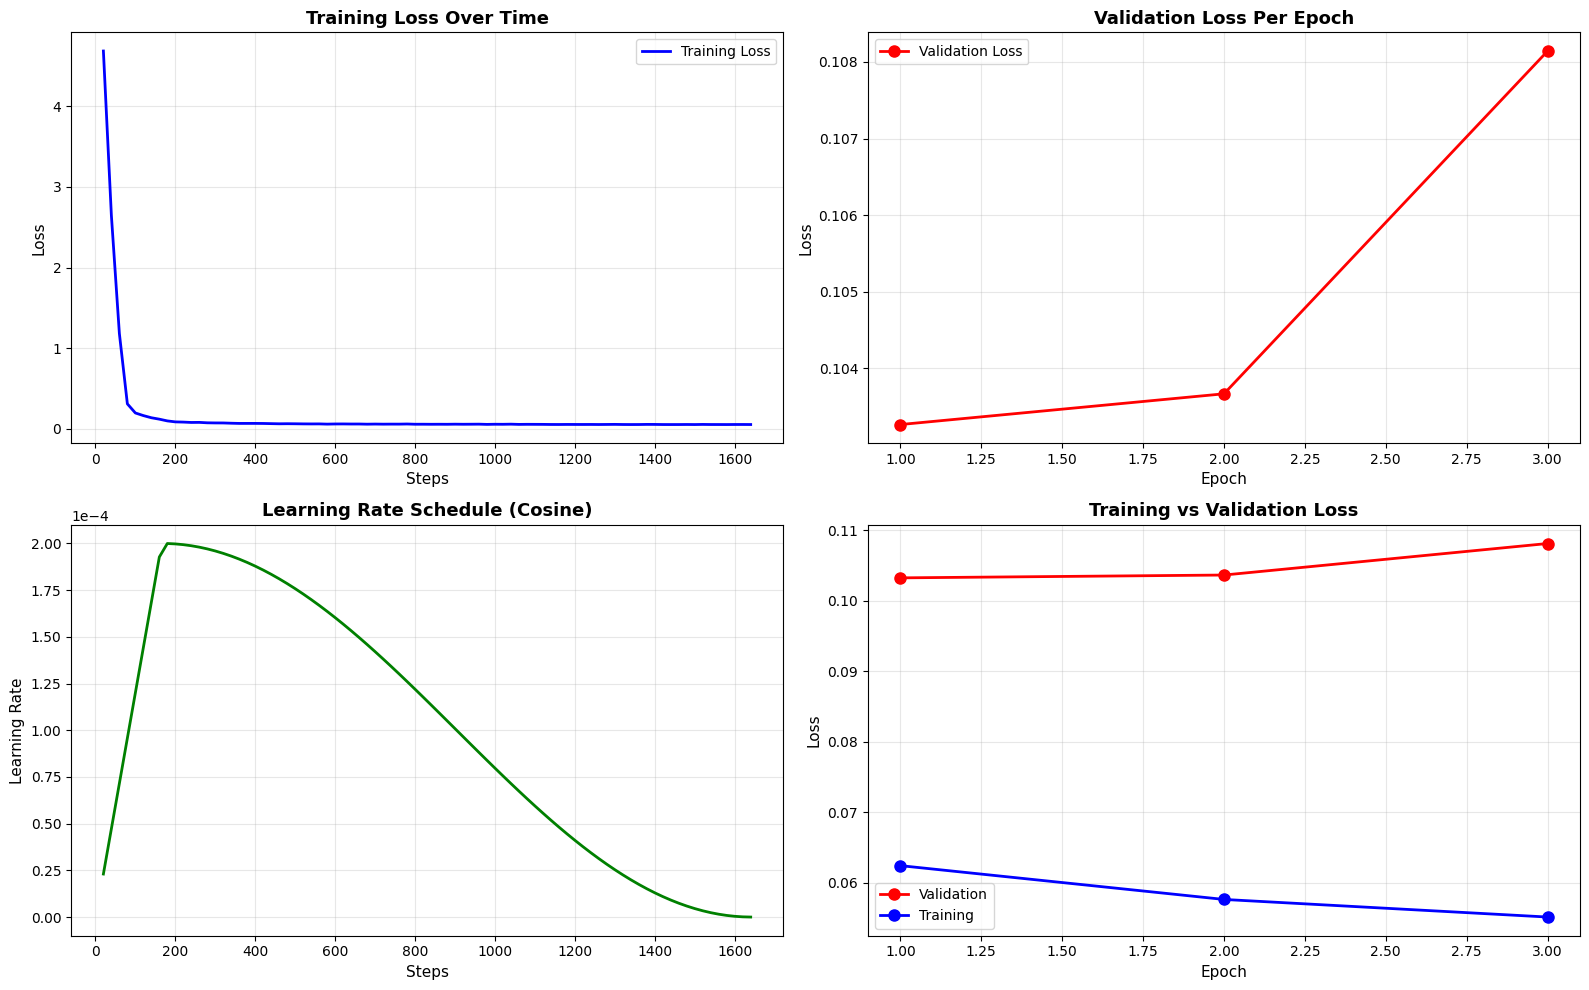


Final Training Metrics:
Final training loss: 0.0551
Final validation loss: 0.1081
Best validation loss: 0.1033


In [17]:
# Extract and visualize training history
history = trainer.state.log_history

train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Training loss
if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    ax1.plot(steps, losses, 'b-', linewidth=2, label='Training Loss')
    ax1.set_xlabel('Steps', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Training Loss Over Time', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

# Validation loss
if eval_logs:
    epochs = list(range(1, len(eval_logs) + 1))
    eval_losses = [log['eval_loss'] for log in eval_logs]
    ax2.plot(epochs, eval_losses, 'r-o', linewidth=2, markersize=8, label='Validation Loss')
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Loss', fontsize=11)
    ax2.set_title('Validation Loss Per Epoch', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

# Learning rate schedule
if train_logs and 'learning_rate' in train_logs[0]:
    steps = [log['step'] for log in train_logs if 'learning_rate' in log]
    lrs = [log['learning_rate'] for log in train_logs if 'learning_rate' in log]
    ax3.plot(steps, lrs, 'g-', linewidth=2)
    ax3.set_xlabel('Steps', fontsize=11)
    ax3.set_ylabel('Learning Rate', fontsize=11)
    ax3.set_title('Learning Rate Schedule (Cosine)', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Training vs Validation loss
if train_logs and eval_logs:
    ax4.plot(epochs, eval_losses, 'r-o', linewidth=2, markersize=8, label='Validation')
    # Sample training loss at epoch boundaries
    epoch_steps = [log['step'] for log in eval_logs]
    epoch_train_losses = []
    for step in epoch_steps:
        closest = min([log for log in train_logs if log['step'] <= step],
                     key=lambda x: abs(x['step'] - step), default=None)
        if closest:
            epoch_train_losses.append(closest['loss'])
    if epoch_train_losses:
        ax4.plot(epochs[:len(epoch_train_losses)], epoch_train_losses,
                'b-o', linewidth=2, markersize=8, label='Training')
    ax4.set_xlabel('Epoch', fontsize=11)
    ax4.set_ylabel('Loss', fontsize=11)
    ax4.set_title('Training vs Validation Loss', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend()

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFinal Training Metrics:")
print("="*80)
if train_logs:
    final_train_loss = train_logs[-1]['loss']
    print(f"Final training loss: {final_train_loss:.4f}")
if eval_logs:
    final_val_loss = eval_logs[-1]['eval_loss']
    best_val_loss = min(log['eval_loss'] for log in eval_logs)
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Best validation loss: {best_val_loss:.4f}")
print("="*80)

---

# Part 11: Save and Load the Fine-Tuned Model

In [18]:
# Save the fine-tuned model
FINAL_MODEL_DIR = "./functiongemma-ecommerce-final"

print("Saving fine-tuned model...")
model.save_pretrained(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print(f"✅ Model saved to: {FINAL_MODEL_DIR}")

# Save training configuration
config_info = {
    "base_model": MODEL_ID,
    "task": "e-commerce customer support routing",
    "tools": list(ECOMMERCE_TOOLS.keys()),
    "training": {
        "lora_rank": int(lora_config.r),
        "lora_alpha": int(lora_config.lora_alpha),
        "epochs": int(training_args.num_train_epochs),
        "learning_rate": float(training_args.learning_rate),
        "batch_size": int(effective_batch_size),
        "training_samples": len(train_dataset),
        "validation_samples": len(val_dataset),
        "test_samples": len(test_dataset),
    },
    "training_time_minutes": training_time_minutes,
    "timestamp": datetime.now().isoformat(),
}

with open(f"{FINAL_MODEL_DIR}/training_config.json", "w") as f:
    json.dump(config_info, f, indent=2)

print(f"✅ Configuration saved")
print("\nModel is ready for deployment!")

Saving fine-tuned model...
✅ Model saved to: ./functiongemma-ecommerce-final
✅ Configuration saved

Model is ready for deployment!


In [19]:
# Load the fine-tuned model for testing
print("Loading fine-tuned model for evaluation...\n")

# Load base model with quantization
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=compute_dtype,
)

# Load LoRA adapter
finetuned_model = PeftModel.from_pretrained(base_model, FINAL_MODEL_DIR)
finetuned_tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL_DIR)

print("✅ Fine-tuned model loaded and ready for testing!")

Loading fine-tuned model for evaluation...

✅ Fine-tuned model loaded and ready for testing!


## Evaluation Functions

In [21]:
print("\n" + "="*80)
print("SECTION 14: DEFINING EVALUATION FUNCTIONS")
print("="*80)

def test_model(query, model, tokenizer):
    """
    Test model on a single query.

    Returns:
        - predicted_tool: str
        - latency_ms: float
    """

    tool_definitions = """<start_function_declaration>
manage_order(order_id: str, action: str) -> dict:
    Track, update, or cancel customer orders
search_products(query: str, category: str) -> list:
    Search for products, check availability, and get product information
get_product_details(product_id: str) -> dict:
    Get detailed specifications, reviews, and information about a specific product
process_return(order_id: str, reason: str) -> dict:
    Handle product returns, refunds, and exchanges
manage_account(action: str, data: dict) -> dict:
    Update user profile, addresses, and account settings
handle_payment(order_id: str, action: str) -> dict:
    Process payments, update payment methods, and resolve billing issues
technical_help(issue_type: str, description: str) -> dict:
    Resolve technical issues with website, app, or account access
<end_function_declaration>"""

    prompt = f"""<start_of_turn>user
{tool_definitions}

User query: {query}<end_of_turn>
<start_of_turn>model
"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    start = time.time()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=30,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )
    latency = (time.time() - start) * 1000  # Convert to ms

    generated_ids = outputs[0][inputs['input_ids'].shape[1]:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=False)

    # Extract function call
    match = re.search(r'<function_call>\s*([a-zA-Z_]+)\s*</function_call>', generated_text)
    if match:
        return match.group(1).strip(), latency

    return "unknown", latency

print("✅ Evaluation function defined")





SECTION 14: DEFINING EVALUATION FUNCTIONS
✅ Evaluation function defined


## Quick Testing

In [22]:
print("\n" + "="*80)
print("SECTION 15: QUICK TESTING")
print("="*80)

test_queries = [
    "Where's my order?",
    "Show me red dresses",
    "I want to return this item",
    "Update my email address",
    "My payment failed",
    "App won't open",
    "Get product details",
]

print("\nTesting sample queries:\n")
for query in test_queries:
    tool, lat = test_model(query, finetuned_model, finetuned_tokenizer)
    print(f"Query: '{query}'")
    print(f"  → Predicted: {tool} | Latency: {lat:.1f}ms\n")




The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



SECTION 15: QUICK TESTING

Testing sample queries:

Query: 'Where's my order?'
  → Predicted: manage_order | Latency: 1678.0ms

Query: 'Show me red dresses'
  → Predicted: search_products | Latency: 1243.1ms

Query: 'I want to return this item'
  → Predicted: process_return | Latency: 1055.0ms

Query: 'Update my email address'
  → Predicted: manage_account | Latency: 1047.6ms

Query: 'My payment failed'
  → Predicted: handle_payment | Latency: 1047.8ms

Query: 'App won't open'
  → Predicted: technical_help | Latency: 1041.9ms

Query: 'Get product details'
  → Predicted: get_product_details | Latency: 1216.2ms



## Full Evaluation on Test Set

In [38]:
print("\n" + "="*80)
print("SECTION 16: FULL EVALUATION ON TEST SET")
print("="*80)

print(f"\nEvaluating on {len(test_dataset)} test samples...")

results = []
latencies = []

for sample in tqdm(test_dataset.to_list(), desc="Evaluating"):
    text = sample['text']

    # Extract query and expected tool
    query_match = re.search(r'User query: (.+?)<end_of_turn>', text)
    tool_match = re.search(r'<function_call>(.+?)</function_call>', text)

    if query_match and tool_match:
        query = query_match.group(1)
        expected = tool_match.group(1)
        predicted, lat = test_model(query, finetuned_model, finetuned_tokenizer)
        latencies.append(lat)

        results.append({
            'query': query,
            'expected': expected,
            'predicted': predicted,
            'correct': expected == predicted
        })

# Calculate metrics
accuracy = sum(r['correct'] for r in results) / len(results)
correct_count = sum(r['correct'] for r in results)
avg_latency = np.mean(latencies)
median_latency = np.median(latencies)
p95_latency = np.percentile(latencies, 95)
p99_latency = np.percentile(latencies, 99)

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"\n📊 Accuracy: {accuracy:.2%}")
print(f"✅ Correct predictions: {correct_count}/{len(results)}")
print(f"❌ Incorrect predictions: {len(results) - correct_count}/{len(results)}")
print(f"\n⚡ Latency Statistics:")
print(f"   • Average: {avg_latency:.1f}ms")
print(f"   • Median:  {median_latency:.1f}ms")
print(f"   • P95:     {p95_latency:.1f}ms")
print(f"   • P99:     {p99_latency:.1f}ms")
print("="*80)





SECTION 16: FULL EVALUATION ON TEST SET

Evaluating on 1900 test samples...


Evaluating:   0%|          | 0/1900 [00:00<?, ?it/s]


EVALUATION RESULTS

📊 Accuracy: 89.37%
✅ Correct predictions: 1698/1900
❌ Incorrect predictions: 202/1900

⚡ Latency Statistics:
   • Average: 1135.1ms
   • Median:  1071.7ms
   • P95:     1399.5ms
   • P99:     1522.1ms


## Confusion Matrix


SECTION 17: CONFUSION MATRIX


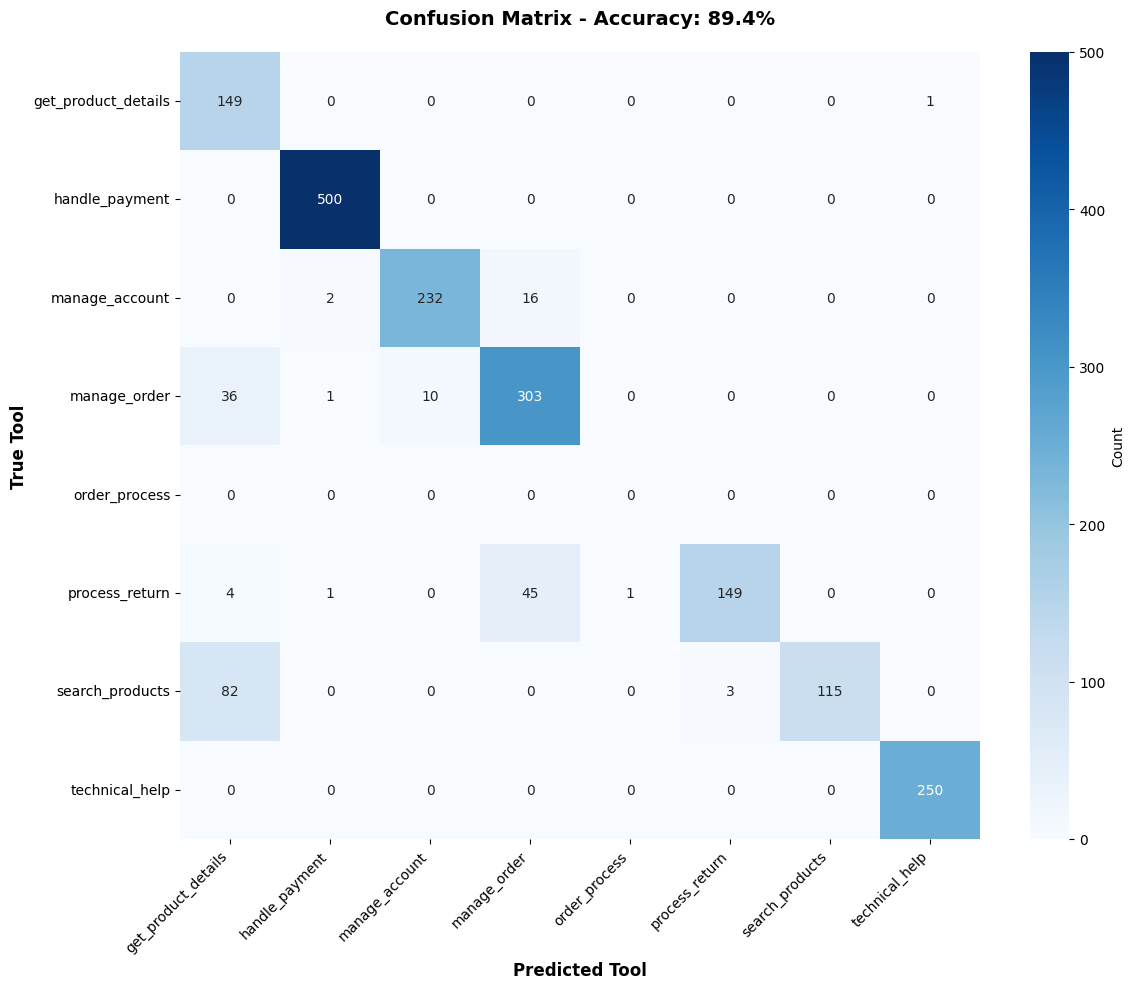

✅ Confusion matrix saved!


In [39]:
print("\n" + "="*80)
print("SECTION 17: CONFUSION MATRIX")
print("="*80)

y_true = [r['expected'] for r in results]
y_pred = [r['predicted'] for r in results]
tools = sorted(list(set(y_true + y_pred)))

cm = confusion_matrix(y_true, y_pred, labels=tools)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tools, yticklabels=tools,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Tool', fontsize=12, fontweight='bold')
plt.ylabel('True Tool', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.1%}', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved!")




## Per-Tool Performance Analysis


SECTION 18: PER-TOOL PERFORMANCE ANALYSIS

--- Classification Report ---
                     precision    recall  f1-score   support

get_product_details      0.550     0.993     0.708       150
     handle_payment      0.992     1.000     0.996       500
     manage_account      0.959     0.928     0.943       250
       manage_order      0.832     0.866     0.849       350
      order_process      0.000     0.000     0.000         0
     process_return      0.980     0.745     0.847       200
    search_products      1.000     0.575     0.730       200
     technical_help      0.996     1.000     0.998       250

           accuracy                          0.894      1900
          macro avg      0.789     0.763     0.759      1900
       weighted avg      0.923     0.894     0.896      1900



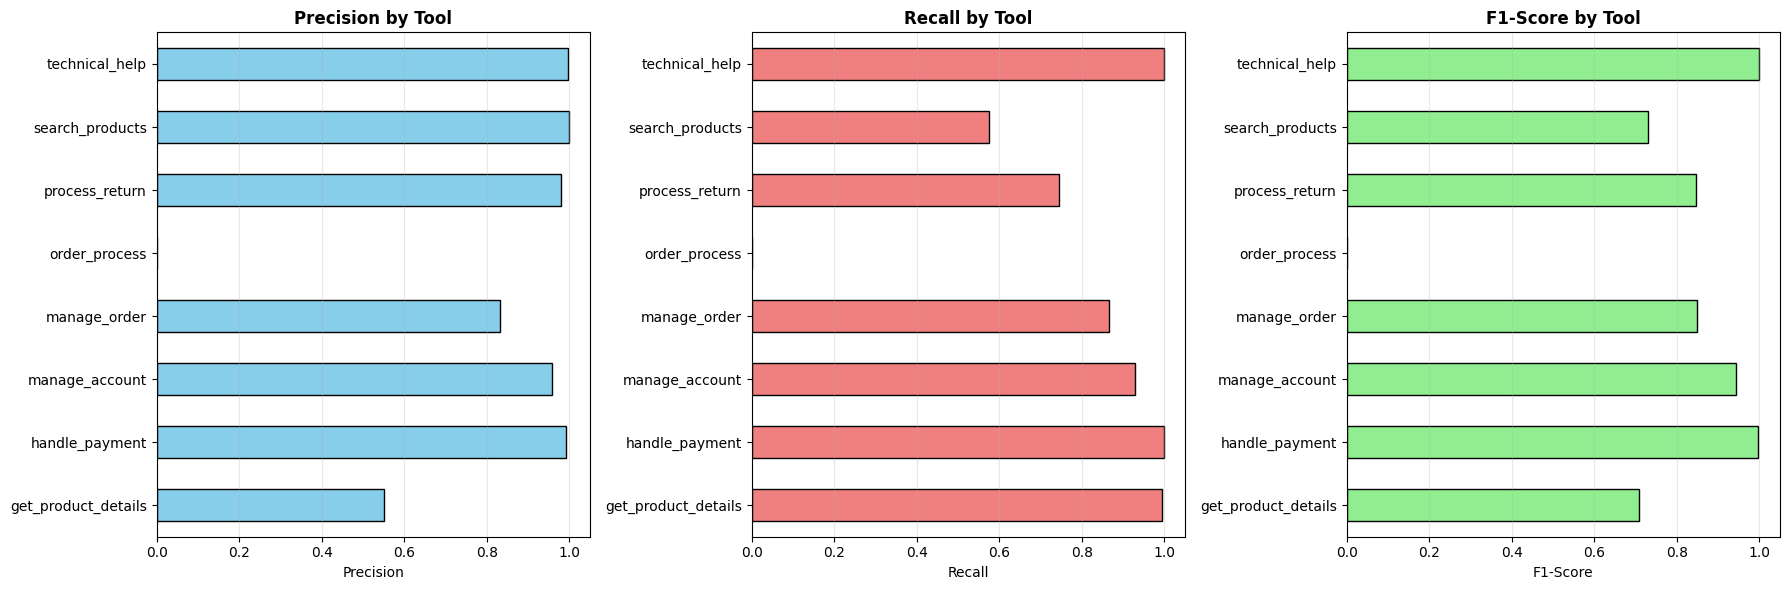


✅ Per-tool metrics visualized!


In [40]:
print("\n" + "="*80)
print("SECTION 18: PER-TOOL PERFORMANCE ANALYSIS")
print("="*80)

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=tools, digits=3))

# Calculate per-tool metrics manually for visualization
tool_metrics = {}
for tool in tools:
    tp = sum(1 for t, p in zip(y_true, y_pred) if t == tool and p == tool)
    fp = sum(1 for t, p in zip(y_true, y_pred) if t != tool and p == tool)
    fn = sum(1 for t, p in zip(y_true, y_pred) if t == tool and p != tool)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    tool_metrics[tool] = {'precision': precision, 'recall': recall, 'f1': f1}

# Visualize per-tool metrics
metrics_df = pd.DataFrame(tool_metrics).T
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_df['precision'].plot(kind='barh', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Precision by Tool', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Precision')
axes[0].set_xlim([0, 1.05])
axes[0].grid(axis='x', alpha=0.3)

metrics_df['recall'].plot(kind='barh', ax=axes[1], color='lightcoral', edgecolor='black')
axes[1].set_title('Recall by Tool', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Recall')
axes[1].set_xlim([0, 1.05])
axes[1].grid(axis='x', alpha=0.3)

metrics_df['f1'].plot(kind='barh', ax=axes[2], color='lightgreen', edgecolor='black')
axes[2].set_title('F1-Score by Tool', fontsize=12, fontweight='bold')
axes[2].set_xlabel('F1-Score')
axes[2].set_xlim([0, 1.05])
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('per_tool_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Per-tool metrics visualized!")




## Error Analysis

In [26]:
print("\n" + "="*80)
print("SECTION 19: ERROR ANALYSIS")
print("="*80)

# Find misclassified samples
errors = [r for r in results if not r['correct']]

print(f"\nTotal errors: {len(errors)}")

if errors:
    print("\n--- Sample Errors ---")
    for i, error in enumerate(errors[:5], 1):  # Show first 5 errors
        print(f"\n{i}. Query: '{error['query']}'")
        print(f"   Expected: {error['expected']}")
        print(f"   Predicted: {error['predicted']}")

    # Error distribution
    error_by_tool = Counter([e['expected'] for e in errors])
    print("\n--- Errors by True Tool ---")
    for tool, count in error_by_tool.most_common():
        print(f"  {tool}: {count} errors")
else:
    print("\n🎉 Perfect accuracy - no errors!")





SECTION 19: ERROR ANALYSIS

Total errors: 1

--- Sample Errors ---

1. Query: 'SHOW NEW ARRIVALS'
   Expected: search_products
   Predicted: get_product_details

--- Errors by True Tool ---
  search_products: 1 errors


## Performance Dashboard


SECTION 20: PERFORMANCE DASHBOARD


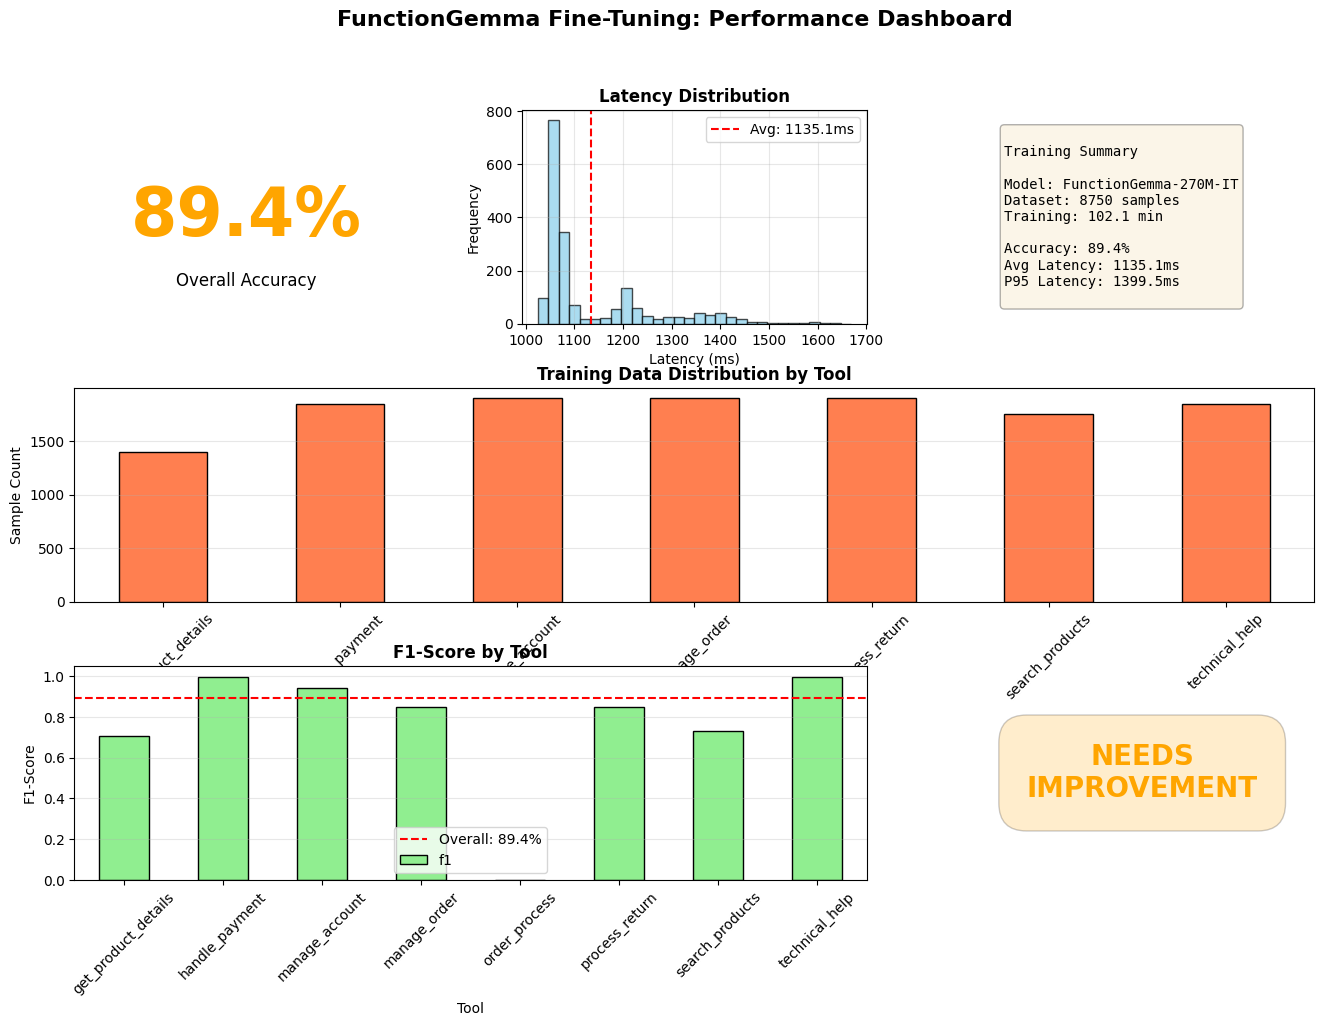


✅ Performance dashboard created!


In [41]:
print("\n" + "="*80)
print("SECTION 20: PERFORMANCE DASHBOARD")
print("="*80)

# Create comprehensive dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Accuracy gauge
ax1 = fig.add_subplot(gs[0, 0])
ax1.text(0.5, 0.5, f'{accuracy:.1%}',
         ha='center', va='center', fontsize=48, fontweight='bold',
         color='green' if accuracy > 0.95 else 'orange')
ax1.text(0.5, 0.2, 'Overall Accuracy', ha='center', va='center', fontsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

# 2. Latency distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(latencies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax2.axvline(avg_latency, color='red', linestyle='--', label=f'Avg: {avg_latency:.1f}ms')
ax2.set_title('Latency Distribution', fontweight='bold')
ax2.set_xlabel('Latency (ms)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Training summary
training_time = training_time_minutes
ax3 = fig.add_subplot(gs[0, 2])
summary_text = f"""
Training Summary

Model: FunctionGemma-270M-IT
Dataset: {len(train_formatted)} samples
Training: {training_time:.1f} min

Accuracy: {accuracy:.1%}
Avg Latency: {avg_latency:.1f}ms
P95 Latency: {p95_latency:.1f}ms
"""
ax3.text(0.1, 0.5, summary_text, ha='left', va='center', fontsize=10,
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax3.axis('off')

# 4. Tool distribution
ax4 = fig.add_subplot(gs[1, :])
tool_counts.plot(kind='bar', ax=ax4, color='coral', edgecolor='black')
ax4.set_title('Training Data Distribution by Tool', fontweight='bold')
ax4.set_xlabel('Tool')
ax4.set_ylabel('Sample Count')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

# 5. F1-scores
ax5 = fig.add_subplot(gs[2, :2])
metrics_df['f1'].plot(kind='bar', ax=ax5, color='lightgreen', edgecolor='black')
ax5.set_title('F1-Score by Tool', fontweight='bold')
ax5.set_xlabel('Tool')
ax5.set_ylabel('F1-Score')
ax5.set_ylim([0, 1.05])
ax5.tick_params(axis='x', rotation=45)
ax5.grid(axis='y', alpha=0.3)
ax5.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall: {accuracy:.1%}')
ax5.legend()

# 6. Status indicator
ax6 = fig.add_subplot(gs[2, 2])
status = "PRODUCTION\nREADY" if accuracy > 0.95 else "NEEDS\nIMPROVEMENT"
color = 'green' if accuracy > 0.95 else 'orange'
ax6.text(0.5, 0.5, status, ha='center', va='center',
         fontsize=20, fontweight='bold', color=color,
         bbox=dict(boxstyle='round', facecolor=color, alpha=0.2, pad=1))
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)
ax6.axis('off')

plt.suptitle('FunctionGemma Fine-Tuning: Performance Dashboard',
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig('performance_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Performance dashboard created!")




# FINAL SUMMARY

In [42]:
print("\n" + "="*80)
print("🎉 NOTEBOOK 1 COMPLETE!")
print("="*80)

print(f"""
Summary:
--------
✅ Dataset Generated: {len(train_formatted)} samples
✅ Model Fine-tuned: {training_time:.1f} minutes
✅ Final Accuracy: {accuracy:.2%}
✅ Average Latency: {avg_latency:.1f}ms
✅ Model Saved: {OUTPUT_DIR}

Generated Visualizations:
------------------------
1. distribution_analysis.png - Dataset distribution
2. length_analysis.png - Query length statistics
3. wordcloud_all.png - Overall word cloud
4. wordcloud_by_tool.png - Per-tool word clouds
5. data_splits.png - Train/val/test splits
6. confusion_matrix.png - Prediction confusion matrix
7. per_tool_metrics.png - Precision/Recall/F1 by tool
8. performance_dashboard.png - Comprehensive dashboard

Next Steps:
-----------
→ Single-Agent Multi-Task System

Your model is {'READY FOR PRODUCTION! 🚀' if accuracy > 0.95 else 'trained but may need improvement.'}
""")

print("="*80)




🎉 NOTEBOOK 1 COMPLETE!

Summary:
--------
✅ Dataset Generated: 8750 samples
✅ Model Fine-tuned: 102.1 minutes
✅ Final Accuracy: 89.37%
✅ Average Latency: 1135.1ms
✅ Model Saved: ./functiongemma-ecommerce-support

Generated Visualizations:
------------------------
1. distribution_analysis.png - Dataset distribution
2. length_analysis.png - Query length statistics
3. wordcloud_all.png - Overall word cloud
4. wordcloud_by_tool.png - Per-tool word clouds
5. data_splits.png - Train/val/test splits
6. confusion_matrix.png - Prediction confusion matrix
7. per_tool_metrics.png - Precision/Recall/F1 by tool
8. performance_dashboard.png - Comprehensive dashboard

Next Steps:
-----------
→ Single-Agent Multi-Task System

Your model is trained but may need improvement.



In [20]:
! zip -r functiongemma-ecommerce-final.zip functiongemma-ecommerce-final

  adding: functiongemma-ecommerce-final/ (stored 0%)
  adding: functiongemma-ecommerce-final/adapter_model.safetensors (deflated 53%)
  adding: functiongemma-ecommerce-final/special_tokens_map.json (deflated 72%)
  adding: functiongemma-ecommerce-final/added_tokens.json (deflated 19%)
  adding: functiongemma-ecommerce-final/adapter_config.json (deflated 58%)
  adding: functiongemma-ecommerce-final/tokenizer_config.json (deflated 97%)
  adding: functiongemma-ecommerce-final/chat_template.jinja (deflated 84%)
  adding: functiongemma-ecommerce-final/README.md (deflated 65%)
  adding: functiongemma-ecommerce-final/training_config.json (deflated 46%)
  adding: functiongemma-ecommerce-final/tokenizer.model (deflated 52%)
  adding: functiongemma-ecommerce-final/tokenizer.json (deflated 83%)


===============================================================================
Single-Agent Multi-Task Routing System
===============================================================================

This tutorial demonstrates:
- Loading the fine-tuned FunctionGemma model
- Building a Universal Agent that handles all tasks
- Dynamic task switching and context management
- Comparing single-agent vs multi-agent architectures
- Performance analysis and trade-offs
- Architecture recommendations

Prerequisites:
- trained model at ./functiongemma-ecommerce-final/

Expected Duration: 30-45 minutes

===============================================================================


In [28]:
print("\n" + "="*80)
print("SECTION 2: SINGLE-AGENT ARCHITECTURE OVERVIEW")
print("="*80)

print("""
Architecture Pattern: Universal Agent

┌─────────────────────────────────────────────────────────────┐
│                   UNIVERSAL AGENT                           │
│  • Handles ALL 7 task types                                 │
│  • Dynamic task switching                                   │
│  • Context-aware conversation                               │
│  • Simpler deployment                                       │
└─────────────────────┬───────────────────────────────────────┘
                      │
                      ▼
         ┌───────────────────────┐
         │  FunctionGemma Model  │
         │  (Fine-tuned Router)  │
         └───────────┬───────────┘
                     │
        ┌────────────┴─────────────┬─────────────┬──────────┐
        ▼                          ▼             ▼          ▼
  ┌──────────┐              ┌──────────┐  ┌──────────┐  ┌──────────┐
  │  Order   │              │ Product  │  │ Returns  │  │ Account  │
  │ Logic    │              │ Logic    │  │ Logic    │  │ Logic    │
  └──────────┘              └──────────┘  └──────────┘  └──────────┘
                  ┌──────────┐  ┌──────────┐  ┌──────────┐
                  │ Payment  │  │Technical │  │ Product  │
                  │ Logic    │  │ Logic    │  │Details   │
                  └──────────┘  └──────────┘  └──────────┘

Benefits:
• Simpler architecture
• Lower operational overhead
• Single deployment unit
• Shared context across tasks

Trade-offs:
• All logic in one agent
• Single point of failure
• Harder to scale individual features
• More complex agent implementation
""")

print("✅ Architecture defined")





SECTION 2: SINGLE-AGENT ARCHITECTURE OVERVIEW

Architecture Pattern: Universal Agent

┌─────────────────────────────────────────────────────────────┐
│                   UNIVERSAL AGENT                           │
│  • Handles ALL 7 task types                                 │
│  • Dynamic task switching                                   │
│  • Context-aware conversation                               │
│  • Simpler deployment                                       │
└─────────────────────┬───────────────────────────────────────┘
                      │
                      ▼
         ┌───────────────────────┐
         │  FunctionGemma Model  │
         │  (Fine-tuned Router)  │
         └───────────┬───────────┘
                     │
        ┌────────────┴─────────────┬─────────────┬──────────┐
        ▼                          ▼             ▼          ▼
  ┌──────────┐              ┌──────────┐  ┌──────────┐  ┌──────────┐
  │  Order   │              │ Product  │  │ Returns  │  │ Acc

## Data Structures

In [31]:
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Any, Tuple
print("\n" + "="*80)
print("SECTION 3: DEFINING DATA STRUCTURES")
print("="*80)

class TaskType(Enum):
    """Enumeration of task types the agent can handle."""
    MANAGE_ORDER = "manage_order"
    SEARCH_PRODUCTS = "search_products"
    GET_PRODUCT_DETAILS = "get_product_details"
    PROCESS_RETURN = "process_return"
    MANAGE_ACCOUNT = "manage_account"
    HANDLE_PAYMENT = "handle_payment"
    TECHNICAL_HELP = "technical_help"

@dataclass
class ConversationContext:
    """
    Maintains conversation state across multiple interactions.
    """
    user_id: str
    session_id: str
    history: List[Dict[str, Any]] = field(default_factory=list)
    current_task: Optional[str] = None
    metadata: Dict[str, Any] = field(default_factory=dict)

    def add_interaction(self, query: str, response: Dict[str, Any]):
        """Add interaction to history."""
        self.history.append({
            "query": query,
            "response": response,
            "timestamp": time.time(),
            "task": response.get("task")
        })

    def get_last_task(self) -> Optional[str]:
        """Get the last task performed."""
        if self.history:
            return self.history[-1].get("task")
        return None

    def get_task_count(self, task: str) -> int:
        """Count how many times a task was performed."""
        return sum(1 for h in self.history if h.get("task") == task)

@dataclass
class TaskResult:
    """Result from task execution."""
    success: bool
    task: str
    message: str
    data: Optional[Dict[str, Any]] = None
    confidence: float = 1.0
    latency_ms: float = 0.0
    needs_escalation: bool = False

print("✅ Data structures defined:")
print(f"   • TaskType enum with {len(TaskType)} task types")
print(f"   • ConversationContext for state management")
print(f"   • TaskResult for unified responses")


SECTION 3: DEFINING DATA STRUCTURES
✅ Data structures defined:
   • TaskType enum with 7 task types
   • ConversationContext for state management
   • TaskResult for unified responses


## Universal Agent Implementation


In [32]:
print("\n" + "="*80)
print("SECTION 4: IMPLEMENTING UNIVERSAL AGENT")
print("="*80)

class UniversalAgent:
    """
    Universal agent that handles all task types.

    This agent:
    1. Uses FunctionGemma to route queries
    2. Executes appropriate business logic
    3. Maintains conversation context
    4. Handles task switching seamlessly

    Advantages:
    - Single deployment
    - Shared context
    - Simpler orchestration

    Disadvantages:
    - Monolithic
    - Harder to scale specific features
    - Single point of failure
    """

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

        # Task handlers map
        self.task_handlers = {
            TaskType.MANAGE_ORDER.value: self._handle_order_management,
            TaskType.SEARCH_PRODUCTS.value: self._handle_product_search,
            TaskType.GET_PRODUCT_DETAILS.value: self._handle_product_details,
            TaskType.PROCESS_RETURN.value: self._handle_returns,
            TaskType.MANAGE_ACCOUNT.value: self._handle_account,
            TaskType.HANDLE_PAYMENT.value: self._handle_payment,
            TaskType.TECHNICAL_HELP.value: self._handle_technical,
        }

        # Statistics
        self.total_requests = 0
        self.task_counts = Counter()
        self.task_switches = 0
        self.routing_times = []
        self.execution_times = []

        print(f"✅ Universal Agent initialized")
        print(f"   Handling {len(self.task_handlers)} task types")

    def route_query(self, query: str) -> Tuple[str, float]:
      """
      Route query to appropriate task using fine-tuned model.
      Uses EXACT format from training.

      Returns:
          (task_name, latency_ms)
      """

      # EXACT same format as training - NO CHANGES!
      tool_definitions = """<start_function_declaration>
manage_order(order_id: str, action: str) -> dict:
    Track, update, or cancel customer orders
search_products(query: str, category: str) -> list:
    Search for products, check availability, and get product information
get_product_details(product_id: str) -> dict:
    Get detailed specifications, reviews, and information about a specific product
process_return(order_id: str, reason: str) -> dict:
    Handle product returns, refunds, and exchanges
manage_account(action: str, data: dict) -> dict:
    Update user profile, addresses, and account settings
handle_payment(order_id: str, action: str) -> dict:
    Process payments, update payment methods, and resolve billing issues
technical_help(issue_type: str, description: str) -> dict:
    Resolve technical issues with website, app, or account access
<end_function_declaration>"""

      # CRITICAL: Newline after <start_of_turn>model (just like training!)
      prompt = f"""<start_of_turn>user
{tool_definitions}

User query: {query}<end_of_turn>
<start_of_turn>model
"""

      # Tokenize
      inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

      # Generate
      start = time.time()
      with torch.no_grad():
          outputs = self.model.generate(
              **inputs,
              max_new_tokens=30,
              do_sample=False,
              pad_token_id=self.tokenizer.eos_token_id,
          )
      latency = (time.time() - start) * 1000

      # Decode only the generated part
      generated_ids = outputs[0][inputs['input_ids'].shape[1]:]
      generated_text = self.tokenizer.decode(generated_ids, skip_special_tokens=False)

      # Extract function call
      match = re.search(r'<function_call>\s*([a-zA-Z_]+)\s*</function_call>', generated_text)
      if match:
          task = match.group(1).strip()
      else:
          task = "unknown"

      # Store timing
      self.routing_times.append(latency)

      return task, latency

    # Task handlers (business logic for each task type)

    def _handle_order_management(self, query: str, context: ConversationContext, **kwargs) -> Dict[str, Any]:
        """Handle order management tasks."""
        time.sleep(0.05)  # Simulate processing

        return {
            "message": "Order ORD-12345 is shipped. Estimated delivery: 2-3 business days.",
            "data": {
                "order_id": "ORD-12345",
                "status": "Shipped",
                "tracking": "TRK123456789",
                "estimated_delivery": "2-3 business days"
            },
            "confidence": 0.95
        }

    def _handle_product_search(self, query: str, context: ConversationContext, **kwargs) -> Dict[str, Any]:
        """Handle product search tasks."""
        time.sleep(0.05)

        return {
            "message": "Found 3 products matching your search",
            "data": {
                "results": [
                    {"id": "PRD-001", "name": "Red Summer Dress", "price": 49.99},
                    {"id": "PRD-002", "name": "Red Evening Gown", "price": 129.99},
                    {"id": "PRD-003", "name": "Red Casual Dress", "price": 39.99}
                ],
                "total": 3
            },
            "confidence": 0.92
        }

    def _handle_product_details(self, query: str, context: ConversationContext, **kwargs) -> Dict[str, Any]:
        """Handle product details requests."""
        time.sleep(0.05)

        # Check if user just searched for products (context-aware)
        last_task = context.get_last_task()
        context_hint = ""
        if last_task == "search_products":
            context_hint = " (based on your recent search)"

        return {
            "message": f"Product details retrieved{context_hint}",
            "data": {
                "product_id": "PRD-001",
                "name": "Premium Wireless Headphones",
                "price": 199.99,
                "specs": {
                    "battery": "30 hours",
                    "connectivity": "Bluetooth 5.0"
                },
                "rating": 4.5
            },
            "confidence": 0.98
        }

    def _handle_returns(self, query: str, context: ConversationContext, **kwargs) -> Dict[str, Any]:
        """Handle returns and refunds."""
        time.sleep(0.05)

        return {
            "message": "Return initiated successfully. Return ID: RET-78901",
            "data": {
                "return_id": "RET-78901",
                "status": "Initiated",
                "refund_amount": 49.99,
                "estimated_refund": "5-7 business days"
            },
            "confidence": 0.90
        }

    def _handle_account(self, query: str, context: ConversationContext, **kwargs) -> Dict[str, Any]:
        """Handle account management."""
        time.sleep(0.05)

        return {
            "message": "Account updated successfully",
            "data": {
                "action": "profile_update",
                "fields_updated": ["email"],
                "status": "completed"
            },
            "confidence": 0.96
        }

    def _handle_payment(self, query: str, context: ConversationContext, **kwargs) -> Dict[str, Any]:
        """Handle payment issues."""
        time.sleep(0.05)

        # Check for fraud keywords
        fraud_keywords = ["fraud", "unauthorized", "stolen"]
        needs_escalation = any(kw in query.lower() for kw in fraud_keywords)

        return {
            "message": "Payment issue resolved" if not needs_escalation else "Payment issue flagged for review",
            "data": {
                "action": "payment_retry",
                "status": "successful" if not needs_escalation else "pending_review",
                "transaction_id": "TXN-54321"
            },
            "confidence": 0.88 if not needs_escalation else 0.65,
            "needs_escalation": needs_escalation
        }

    def _handle_technical(self, query: str, context: ConversationContext, **kwargs) -> Dict[str, Any]:
        """Handle technical support."""
        time.sleep(0.05)

        critical_keywords = ["not working", "broken", "crash"]
        is_critical = any(kw in query.lower() for kw in critical_keywords)

        return {
            "message": f"Technical support ticket created (Priority: {'High' if is_critical else 'Normal'})",
            "data": {
                "ticket_id": "TECH-99999",
                "priority": "high" if is_critical else "normal",
                "estimated_resolution": "24 hours"
            },
            "confidence": 0.85,
            "needs_escalation": is_critical
        }

    def process_query(self, query: str, context: ConversationContext, **kwargs) -> TaskResult:
        """
        Process a query through the universal agent.

        Steps:
        1. Route to appropriate task
        2. Check for task switch
        3. Execute task handler
        4. Update context
        5. Return result
        """

        self.total_requests += 1

        # Step 1: Route query
        task, routing_latency = self.route_query(query)
        self.task_counts[task] += 1

        # Step 2: Check for task switch
        previous_task = context.get_last_task()
        if previous_task and previous_task != task:
            self.task_switches += 1
            print(f"   🔄 Task switch: {previous_task} → {task}")

        # Step 3: Execute handler
        handler = self.task_handlers.get(task)

        if not handler:
            return TaskResult(
                success=False,
                task=task,
                message=f"Unknown task: {task}",
                confidence=0.0,
                latency_ms=routing_latency
            )

        exec_start = time.time()
        try:
            handler_result = handler(query, context, **kwargs)
            exec_latency = (time.time() - exec_start) * 1000
            self.execution_times.append(exec_latency)

            total_latency = routing_latency + exec_latency

            result = TaskResult(
                success=True,
                task=task,
                message=handler_result["message"],
                data=handler_result.get("data"),
                confidence=handler_result.get("confidence", 1.0),
                latency_ms=total_latency,
                needs_escalation=handler_result.get("needs_escalation", False)
            )

            # Step 4: Update context
            context.add_interaction(query, result.__dict__)
            context.current_task = task

            return result

        except Exception as e:
            return TaskResult(
                success=False,
                task=task,
                message=f"Error: {str(e)}",
                confidence=0.0,
                latency_ms=routing_latency
            )

    def get_stats(self) -> Dict[str, Any]:
        """Get agent statistics."""
        return {
            "total_requests": self.total_requests,
            "task_switches": self.task_switches,
            "avg_routing_latency_ms": np.mean(self.routing_times) if self.routing_times else 0,
            "avg_execution_latency_ms": np.mean(self.execution_times) if self.execution_times else 0,
            "task_distribution": dict(self.task_counts)
        }

print("✅ Universal Agent implemented")





SECTION 4: IMPLEMENTING UNIVERSAL AGENT
✅ Universal Agent implemented


## Initialize Universal Agent


In [33]:
print("\n" + "="*80)
print("SECTION 6: INITIALIZING UNIVERSAL AGENT")
print("="*80)

universal_agent = UniversalAgent(finetuned_model, tokenizer)

print("\n✅ Universal agent ready!")


SECTION 6: INITIALIZING UNIVERSAL AGENT
✅ Universal Agent initialized
   Handling 7 task types

✅ Universal agent ready!


## Demo - Basic Task Handling


In [34]:
print("\n" + "="*80)
print("SECTION 7: DEMO - BASIC TASK HANDLING")
print("="*80)

# Create a conversation context
context = ConversationContext(
    user_id="user123",
    session_id="session456"
)

test_queries = [
    "Where's my order?",
    "Show me red dresses",
    "Tell me about product PRD-001",
    "I want to return this",
    "Update my email",
    "My payment failed",
    "App is crashing"
]

print(f"\nProcessing {len(test_queries)} queries:\n")

basic_results = []
for query in test_queries:
    print(f"{'─'*80}")
    print(f"Query: '{query}'")

    result = universal_agent.process_query(query, context)
    basic_results.append(result)

    if result.success:
        print(f"✅ Task: {result.task}")
        print(f"   Response: {result.message}")
        print(f"   Confidence: {result.confidence:.0%}")
        print(f"   Latency: {result.latency_ms:.1f}ms")
    else:
        print(f"❌ Error: {result.message}")
    print()

print(f"Context history: {len(context.history)} interactions")



SECTION 7: DEMO - BASIC TASK HANDLING

Processing 7 queries:

────────────────────────────────────────────────────────────────────────────────
Query: 'Where's my order?'
✅ Task: manage_order
   Response: Order ORD-12345 is shipped. Estimated delivery: 2-3 business days.
   Confidence: 95%
   Latency: 1134.2ms

────────────────────────────────────────────────────────────────────────────────
Query: 'Show me red dresses'
   🔄 Task switch: manage_order → search_products
✅ Task: search_products
   Response: Found 3 products matching your search
   Confidence: 92%
   Latency: 1117.9ms

────────────────────────────────────────────────────────────────────────────────
Query: 'Tell me about product PRD-001'
   🔄 Task switch: search_products → get_product_details
✅ Task: get_product_details
   Response: Product details retrieved (based on your recent search)
   Confidence: 98%
   Latency: 1270.4ms

────────────────────────────────────────────────────────────────────────────────
Query: 'I want to

## Demo - Task Switching


In [35]:
print("\n" + "="*80)
print("SECTION 8: DEMO - TASK SWITCHING")
print("="*80)

print("""
Demonstrating how the agent handles rapid task switching
within a single conversation.
""")

# New conversation
switch_context = ConversationContext(
    user_id="user789",
    session_id="session101"
)

switching_queries = [
    "Find red dresses",                      # search_products
    "What's the price?",                     # get_product_details
    "Where's my order ORD-123?",             # manage_order
    "I want to return it",                   # process_return
    "Show me blue jeans",                    # search_products (switch back)
    "Update my shipping address",            # manage_account
    "My payment was declined"                # handle_payment
]

print(f"\nProcessing conversation with {len(switching_queries)} queries:\n")

switch_results = []
for i, query in enumerate(switching_queries, 1):
    print(f"Step {i}: '{query}'")

    result = universal_agent.process_query(query, switch_context)
    switch_results.append(result)

    print(f"   → Task: {result.task} | Latency: {result.latency_ms:.1f}ms")

    if i > 1 and switch_results[-2].task != result.task:
        print(f"   🔄 Task switched!")

    print()

print(f"✅ Processed {len(switching_queries)} queries")
print(f"✅ Task switches: {universal_agent.task_switches}")


SECTION 8: DEMO - TASK SWITCHING

Demonstrating how the agent handles rapid task switching
within a single conversation.


Processing conversation with 7 queries:

Step 1: 'Find red dresses'
   → Task: search_products | Latency: 1159.0ms

Step 2: 'What's the price?'
   🔄 Task switch: search_products → get_product_details
   → Task: get_product_details | Latency: 1286.2ms
   🔄 Task switched!

Step 3: 'Where's my order ORD-123?'
   🔄 Task switch: get_product_details → manage_order
   → Task: manage_order | Latency: 1294.2ms
   🔄 Task switched!

Step 4: 'I want to return it'
   🔄 Task switch: manage_order → process_return
   → Task: process_return | Latency: 1495.1ms
   🔄 Task switched!

Step 5: 'Show me blue jeans'
   🔄 Task switch: process_return → search_products
   → Task: search_products | Latency: 1133.4ms
   🔄 Task switched!

Step 6: 'Update my shipping address'
   🔄 Task switch: search_products → manage_order
   → Task: manage_order | Latency: 1140.7ms
   🔄 Task switched!

Step 7

## Performance Analysis


In [36]:
print("\n" + "="*80)
print("SECTION 10: PERFORMANCE ANALYSIS - SINGLE AGENT")
print("="*80)

agent_stats = universal_agent.get_stats()

print("\n--- Universal Agent Statistics ---")
print(f"Total requests: {agent_stats['total_requests']}")
print(f"Task switches: {agent_stats['task_switches']}")
print(f"Average routing latency: {agent_stats['avg_routing_latency_ms']:.1f}ms")
print(f"Average execution latency: {agent_stats['avg_execution_latency_ms']:.1f}ms")
print(f"Total average latency: {agent_stats['avg_routing_latency_ms'] + agent_stats['avg_execution_latency_ms']:.1f}ms")

print("\n--- Task Distribution ---")
for task, count in sorted(agent_stats['task_distribution'].items(), key=lambda x: x[1], reverse=True):
    percentage = count / agent_stats['total_requests'] * 100
    print(f"  {task}: {count} ({percentage:.1f}%)")



SECTION 10: PERFORMANCE ANALYSIS - SINGLE AGENT

--- Universal Agent Statistics ---
Total requests: 14
Task switches: 12
Average routing latency: 1174.2ms
Average execution latency: 50.1ms
Total average latency: 1224.3ms

--- Task Distribution ---
  manage_order: 3 (21.4%)
  search_products: 3 (21.4%)
  get_product_details: 2 (14.3%)
  process_return: 2 (14.3%)
  handle_payment: 2 (14.3%)
  manage_account: 1 (7.1%)
  technical_help: 1 (7.1%)


## Performance Benchmarking



SECTION 12: PERFORMANCE BENCHMARKING

--- Latency Statistics ---
Total queries: 14
Successful: 14
Average latency: 1224.3ms
Median latency: 1149.8ms
P95 latency: 1489.5ms
P99 latency: 1494.0ms

--- Confidence Statistics ---
Average confidence: 92.4%
Min confidence: 85.0%
Max confidence: 98.0%


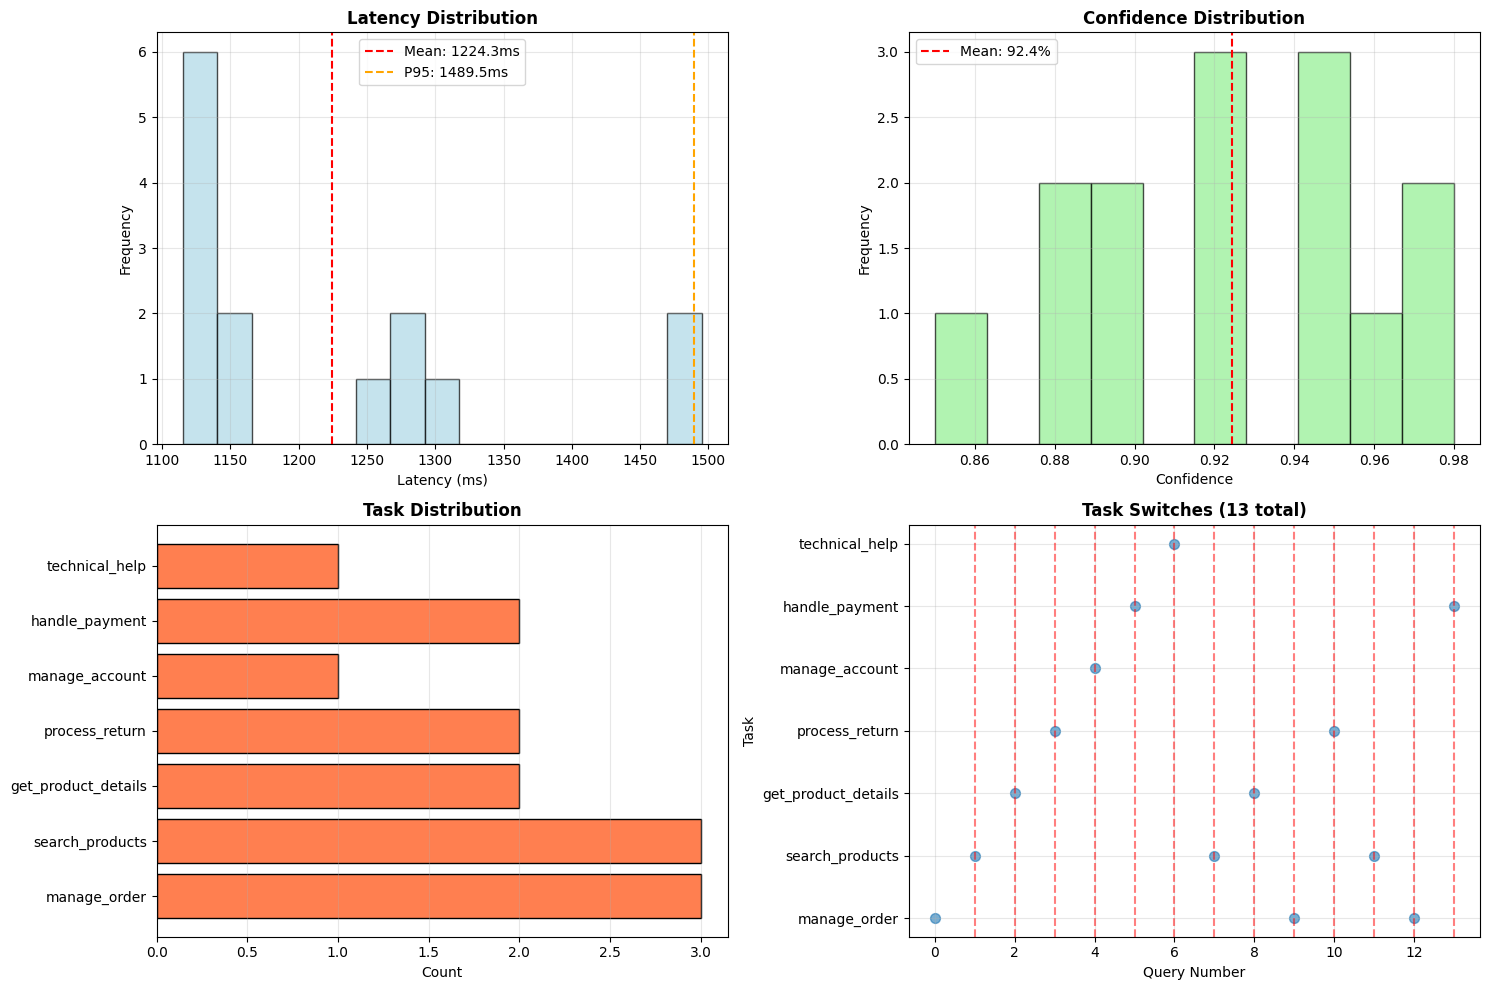


✅ Performance benchmarks visualized!


In [37]:
print("\n" + "="*80)
print("SECTION 12: PERFORMANCE BENCHMARKING")
print("="*80)

# Collect all results
all_results = basic_results + switch_results

successful_results = [r for r in all_results if r.success]
latencies = [r.latency_ms for r in successful_results]
confidences = [r.confidence for r in successful_results]

print(f"\n--- Latency Statistics ---")
print(f"Total queries: {len(all_results)}")
print(f"Successful: {len(successful_results)}")
print(f"Average latency: {np.mean(latencies):.1f}ms")
print(f"Median latency: {np.median(latencies):.1f}ms")
print(f"P95 latency: {np.percentile(latencies, 95):.1f}ms")
print(f"P99 latency: {np.percentile(latencies, 99):.1f}ms")

print(f"\n--- Confidence Statistics ---")
print(f"Average confidence: {np.mean(confidences):.1%}")
print(f"Min confidence: {np.min(confidences):.1%}")
print(f"Max confidence: {np.max(confidences):.1%}")

# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Latency distribution
axes[0, 0].hist(latencies, bins=15, color='lightblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(latencies), color='red', linestyle='--',
                   label=f'Mean: {np.mean(latencies):.1f}ms')
axes[0, 0].axvline(np.percentile(latencies, 95), color='orange', linestyle='--',
                   label=f'P95: {np.percentile(latencies, 95):.1f}ms')
axes[0, 0].set_title('Latency Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Latency (ms)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Confidence distribution
axes[0, 1].hist(confidences, bins=10, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(confidences), color='red', linestyle='--',
                   label=f'Mean: {np.mean(confidences):.1%}')
axes[0, 1].set_title('Confidence Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Confidence')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Task distribution
if agent_stats['task_distribution']:
    tasks = list(agent_stats['task_distribution'].keys())
    counts = list(agent_stats['task_distribution'].values())
    axes[1, 0].barh(tasks, counts, color='coral', edgecolor='black')
    axes[1, 0].set_title('Task Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].grid(axis='x', alpha=0.3)

# Task switches over time
switch_points = []
current_task = None
for i, r in enumerate(all_results):
    if current_task and current_task != r.task:
        switch_points.append(i)
    current_task = r.task

axes[1, 1].scatter(range(len(all_results)), [r.task for r in all_results], alpha=0.6, s=50)
for sp in switch_points:
    axes[1, 1].axvline(sp, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title(f'Task Switches ({len(switch_points)} total)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Query Number')
axes[1, 1].set_ylabel('Task')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('single_agent_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Performance benchmarks visualized!")